## Importación de Dependendias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

2025-12-04 09:54:34.971913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 09:54:35.337398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-04 09:54:36.386574: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Preparación de Datos

### Carga y Exploración Inicial

In [139]:
file_name = "Helicopter_Turboshaft_Fault_Detection.csv"

try:
    # cargar dataset
    df = pd.read_csv(file_name)
    print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    print(f"No se ha encontrado el archivo {file_name} en la carpeta del proyecto")
except Exception as e:
    print(f"Error cargando el archivo: {e}")

Dataset cargado: 7012 filas, 11 columnas


In [140]:
# informacion basica
print("\nINFORMACIÓN DEL DATASET:")
print(df.info())
print(f"\nDimensiones: {df.shape}")


INFORMACIÓN DEL DATASET:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7012 entries, 0 to 7011
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             7012 non-null   object 
 1   Temp_Compressor       7012 non-null   float64
 2   Temp_Turbine          7012 non-null   float64
 3   Pressure_Compressor   7012 non-null   float64
 4   Vibration_Compressor  7012 non-null   float64
 5   Speed_Turbine         7012 non-null   float64
 6   Fuel_Flow             7012 non-null   float64
 7   Altitude              7012 non-null   float64
 8   Airspeed              7012 non-null   float64
 9   Ambient_Temp          7012 non-null   float64
 10  Fault_Label           7012 non-null   object 
dtypes: float64(9), object(2)
memory usage: 602.7+ KB
None

Dimensiones: (7012, 11)


In [141]:
# primeras filas
print("\nPRIMERAS 5 FILAS:")
df.head()


PRIMERAS 5 FILAS:


,Timestamp,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp,Fault_Label
0,2024-03-01 00:00:00,0.516699,-0.482741,1.218923,0.439431,1.109674,0.259894,-0.457097,0.935177,0.520473,Normal
1,2024-03-01 01:00:00,-0.137372,-1.071038,-0.581229,0.165394,-0.344521,0.381376,1.416960,-0.804455,-0.461119,Normal
2,2024-03-01 02:00:00,0.672213,-0.867799,0.268908,1.551952,1.156725,0.647181,0.053060,-1.435661,-1.606553,Normal
3,2024-03-01 03:00:00,1.573874,-1.351055,0.142967,0.176228,0.047683,-1.703167,-1.739264,-0.980834,0.247414,Normal
4,2024-03-01 04:00:00,-0.236144,-0.949079,-1.116520,0.251032,0.122548,-0.376294,0.681555,0.341163,-1.328883,Turbine Blade Damage


In [9]:
# tipos de datos
print("\nTIPOS DE DATOS:")
print(df.dtypes.value_counts())


TIPOS DE DATOS:
float64    9
object     2
Name: count, dtype: int64


In [10]:
# estadisticas descriptivas basicas
print("\nESTADÍSTICAS DESCRIPTIVAS:")
df.describe()


ESTADÍSTICAS DESCRIPTIVAS:


,Temp_Compressor,Temp_Turbine,Pressure_Compressor,Vibration_Compressor,Speed_Turbine,Fuel_Flow,Altitude,Airspeed,Ambient_Temp
count,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03,7.012000e+03
mean,-1.045750e-15,-2.294165e-15,-4.245827e-16,1.504786e-16,6.220796e-15,-1.381161e-15,-3.850631e-17,-9.525245e-17,2.148247e-16
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-2.772926e+00,-2.731452e+00,-2.779824e+00,-2.818930e+00,-2.797912e+00,-2.810185e+00,-1.742798e+00,-1.738476e+00,-2.803083e+00
25%,-6.834192e-01,-6.938367e-01,-6.953875e-01,-7.161923e-01,-6.923787e-01,-6.965294e-01,-8.454536e-01,-8.659915e-01,-7.014270e-01
50%,1.456606e-03,-6.255666e-03,2.105707e-03,1.382664e-02,-6.137782e-03,7.190528e-03,-2.740623e-03,1.511656e-02,2.227411e-03
75%,6.888450e-01,6.816986e-01,6.988208e-01,6.946732e-01,6.977878e-01,7.026591e-01,8.707817e-01,8.738380e-01,6.980463e-01
max,2.779058e+00,2.768032e+00,2.785446e+00,2.790486e+00,2.795210e+00,2.798471e+00,1.726135e+00,1.732903e+00,2.808385e+00


### Limpieza

#### Análisis de valores nulos

In [11]:
# analisis de valores nulos
missing_data = df.isnull().sum()
print(missing_data)

Timestamp               0
Temp_Compressor         0
Temp_Turbine            0
Pressure_Compressor     0
Vibration_Compressor    0
Speed_Turbine           0
Fuel_Flow               0
Altitude                0
Airspeed                0
Ambient_Temp            0
Fault_Label             0
dtype: int64


En este caso, no tenemos valores nulos, así que saltaremos toda la parte de manejo de NAs e interpolación

#### Convertir a formato temporal

De cara a facilitar la gestión de fechas y horas, a continuación convertiremos estos datos a un formato acorde.

In [142]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        
# informacion temporal general
print(f"Primer registro: {df['Timestamp'].min()}")
print(f"Ultimo registro: {df['Timestamp'].max()}")
print(f"Duracion total: {df['Timestamp'].max() - df['Timestamp'].min()}")
        
# verificar frecuencia: en este caso, deberia mantenerse constante a aproximadamente 1h.
diferencias_tiempo = df['Timestamp'].diff().dropna()
frecuencia_esperada = pd.Timedelta(hours=1)
consistencia_frecuencia = (diferencias_tiempo == frecuencia_esperada).mean()
        
print(f"Consistencia de frecuencia (1h): {consistencia_frecuencia:.2%}")

Primer registro: 2024-03-01 00:00:00
Ultimo registro: 2024-12-31 23:00:00
Duracion total: 305 days 23:00:00
Consistencia de frecuencia (1h): 95.46%


Finalmente, guardaremos la dataset, ya limpia

In [13]:
df.to_csv("df_limpio.csv", index=False)

## Análisis Exploratorio de los Datos

#### Detección de Outliers

In [14]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
    
outliers_info = {}
    
for columna in numeric_cols:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
        
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
        
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    porcentaje_outliers = (len(outliers) / len(df)) * 100
        
    outliers_info[columna] = {
        'count': len(outliers),
        'percent': porcentaje_outliers,
        'lower_bound': limite_inferior,
        'upper_bound': limite_superior
    }

In [15]:
resultados_df = pd.DataFrame(outliers_info).T
resultados_df = resultados_df.sort_values('percent', ascending=True)
resultados_df.head(10)

,count,percent,lower_bound,upper_bound
Vibration_Compressor,0.0,0.000000,-2.832491,2.810972
Pressure_Compressor,0.0,0.000000,-2.786700,2.790133
Altitude,0.0,0.000000,-3.419807,3.445135
Airspeed,0.0,0.000000,-3.475736,3.483582
Fuel_Flow,1.0,0.014261,-2.795312,2.801442
Temp_Turbine,1.0,0.014261,-2.757140,2.745002
Ambient_Temp,2.0,0.028523,-2.800637,2.797256
Speed_Turbine,3.0,0.042784,-2.777628,2.783038
Temp_Compressor,4.0,0.057045,-2.741816,2.747241


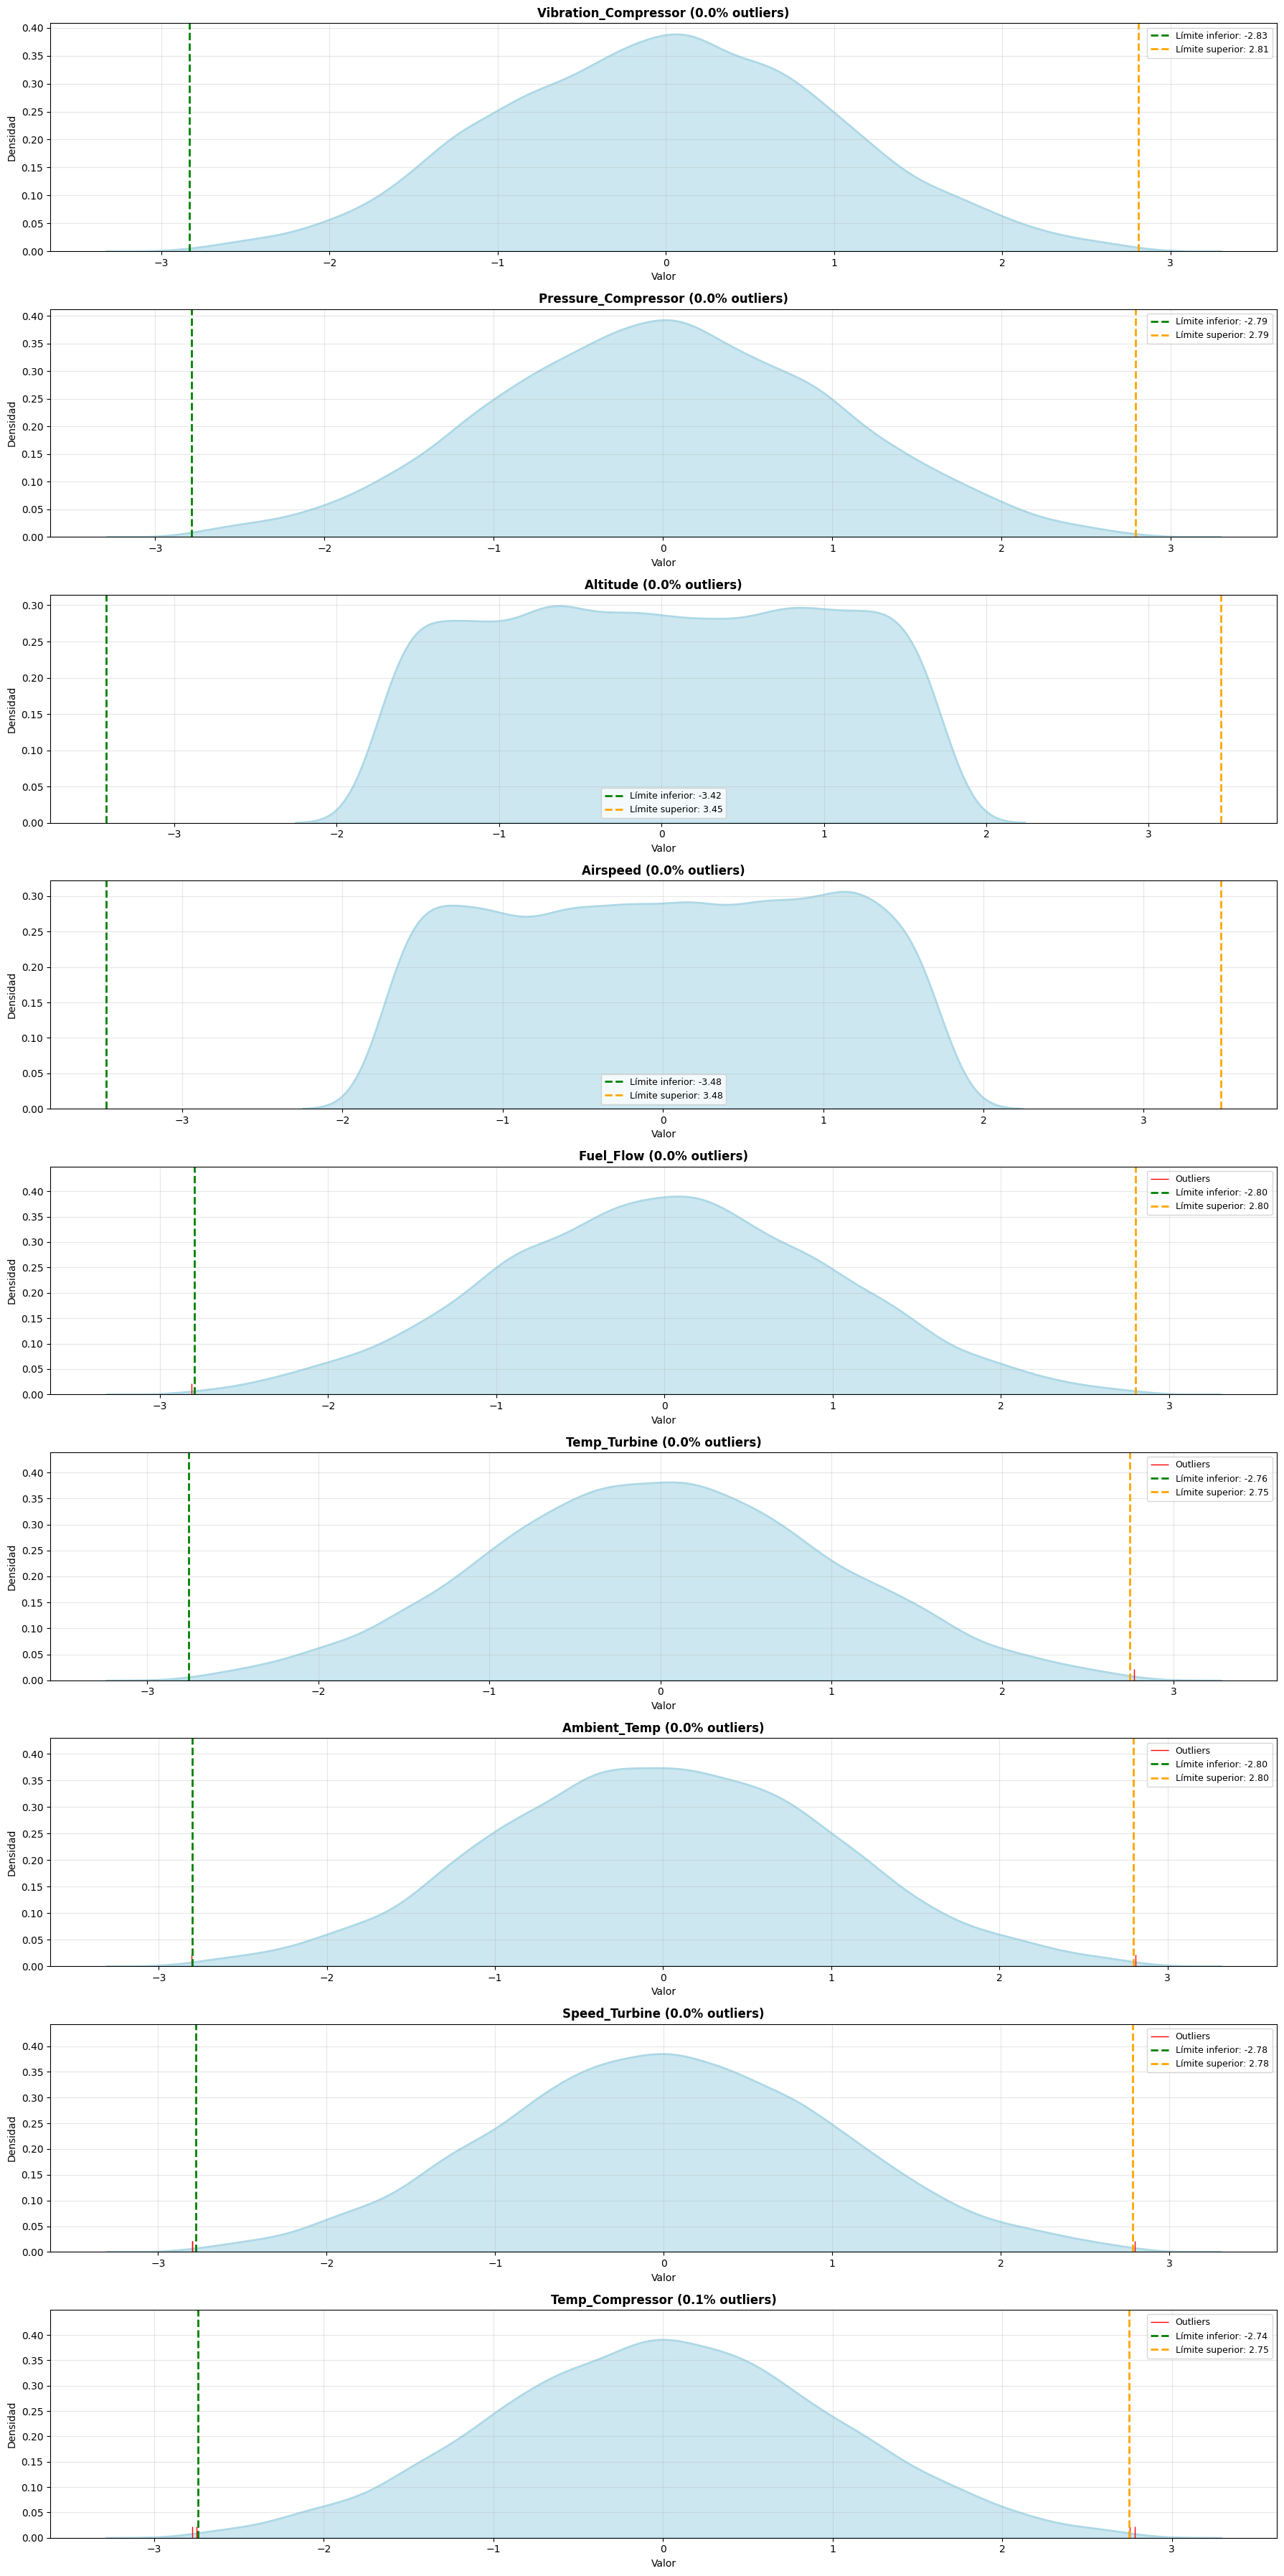

In [16]:
todas_columnas = resultados_df.index.tolist()
fig, axes = plt.subplots(len(todas_columnas), 1, figsize=(18, 4*len(todas_columnas)))


for i, columna in enumerate(todas_columnas):
    ax = axes[i]

    # limites IQR
    lower = resultados_df.loc[columna]['lower_bound']
    upper = resultados_df.loc[columna]['upper_bound']
    outliers_mask = (df[columna] < lower) | (df[columna] > upper)

    # density plot
    sns.kdeplot(df[columna], ax=ax, fill=True, color='lightblue', alpha=0.6, linewidth=2)

    # marcar los outliers
    sns.rugplot(df[columna][outliers_mask], ax=ax, color='red', height=0.05, label='Outliers')

    # pintar las lineas de limites IQR
    ax.axvline(lower, color='green', linestyle='--', linewidth=2, label=f'Límite inferior: {lower:.2f}')
    ax.axvline(upper, color='orange', linestyle='--', linewidth=2, label=f'Límite superior: {upper:.2f}')

    ax.set_title(f'{columna} ({resultados_df.loc[columna]["percent"]:.1f}% outliers)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


En este caso, parece que las variables siguen una distribución coherente con lo que conocemos del dominio, así que obtaremos por conservar los outliers detectados como parte de la dataset.

#### Correlación entre variables

In [17]:
original_data = df[numeric_cols]

# Escalado estándar (z-score)
scaler_standard = StandardScaler()
numeric_cols_scaled = scaler_standard.fit_transform(original_data)

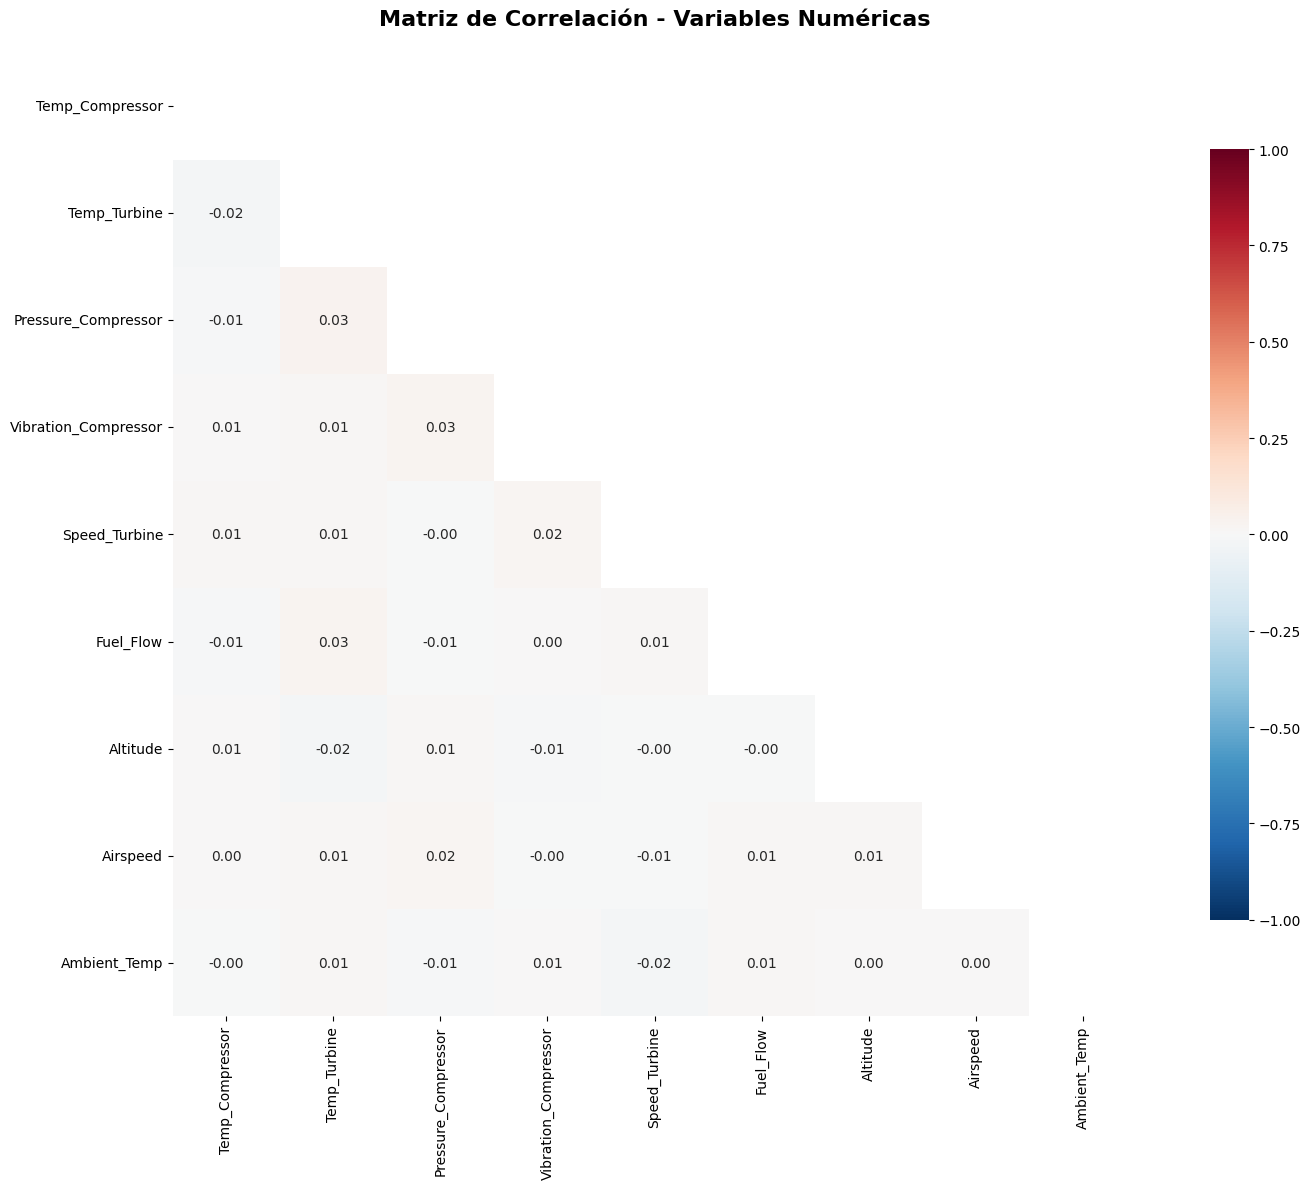

In [18]:
# calcular matriz de correlacion
corr_matrix = pd.DataFrame(numeric_cols_scaled, columns=numeric_cols).corr()

# heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': .8}, vmin=-1, vmax=1
           )

plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [19]:
# top correlaciones (excluyendo autocorrelaciones)
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs.sort_values(ascending=False, key=lambda x: abs(x))

# filtrar autocorrelaciones y duplicados
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs[~corr_pairs.index.duplicated()]

# convertir a df normal
df_corr = corr_pairs.reset_index()
df_corr.columns = ['Variable_1', 'Variable_2', 'Correlación']

df_corr.head(10)


,Variable_1,Variable_2,Correlación
0,Pressure_Compressor,Temp_Turbine,0.032028
1,Temp_Turbine,Pressure_Compressor,0.032028
2,Temp_Turbine,Fuel_Flow,0.028248
3,Fuel_Flow,Temp_Turbine,0.028248
4,Pressure_Compressor,Vibration_Compressor,0.025467
5,Vibration_Compressor,Pressure_Compressor,0.025467
6,Vibration_Compressor,Speed_Turbine,0.021963
7,Speed_Turbine,Vibration_Compressor,0.021963
8,Ambient_Temp,Speed_Turbine,-0.020174
9,Speed_Turbine,Ambient_Temp,-0.020174


## Ingenieria de Caracteristicas

#### Análisis de nuestra variable temporal

In [20]:
# extraer componentes temporales
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['day_of_month'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month
df['weekend'] = (df['Timestamp'].dt.dayofweek >= 5).astype(int)

print("Componentes temporales extraidos:")
print(f"\tHora del día: {df['hour'].unique()}")
print(f"\tDía de la semana: {df['day_of_week'].unique()}")
print(f"\tMes: {df['month'].unique()}")
print(f"\tFin de semana: {df['weekend'].value_counts().to_dict()}")

Componentes temporales extraidos:
	Hora del día: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
	Día de la semana: [4 5 6 0 1 2 3]
	Mes: [ 3  4  5  6  7  8  9 10 11 12]
	Fin de semana: {0: 5001, 1: 2011}


#### Análisis de distribución de fallas

In [21]:
# paleta de fallos
fallos_unicos = df['Fault_Label'].unique().tolist()

# generar paleta con un color por fallo
paleta = sns.color_palette("tab20", len(fallos_unicos))

# mapear cada fallo a un color
color_map = {fault: paleta[i] for i, fault in enumerate(fallos_unicos)}

In [22]:
# crear dataset sin registros "Normal" para visualizacion de fallos
df_fallas = df[df['Fault_Label'] != 'Normal']

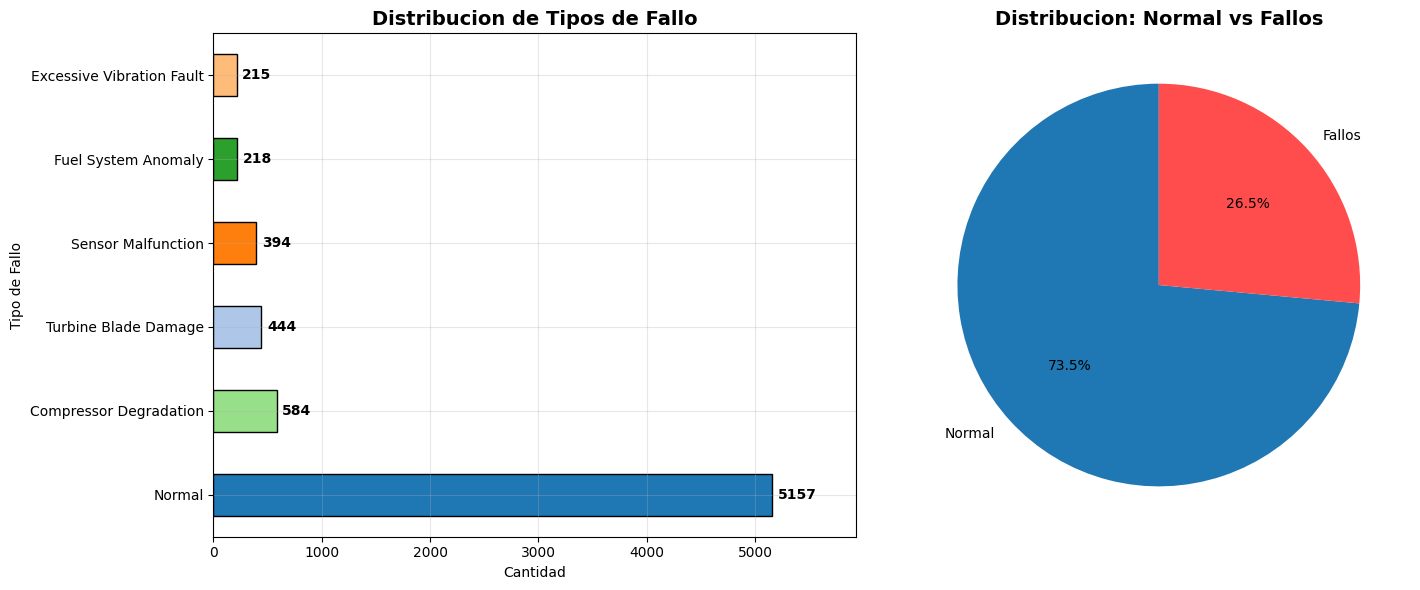

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# bar chart
fault_distribution = df['Fault_Label'].value_counts()
fault_distribution.plot(
    kind='barh',
    ax=ax1,
    color=[color_map[f] for f in fault_distribution.index],
    edgecolor='black'
)
ax1.set_title('Distribucion de Tipos de Fallo', fontweight='bold', fontsize=14)
ax1.set_xlabel('Cantidad')
ax1.set_ylabel('Tipo de Fallo')
ax1.grid(True, alpha=0.3)
max_val = max(fault_distribution)
ax1.set_xlim(0, max_val * 1.15) # pa que normal no sobresalga por la derecha
for i, v in enumerate(fault_distribution):
    ax1.text(v + 0.01 * max_val, i, str(v), va='center', ha='left', fontweight='bold')

# pie chart Normal vs Fallos
conteos = [len(df[df['Fault_Label'] == 'Normal']), len(df_fallas)]
pie_colors = [color_map['Normal'], '#ff4c4c']  # Normal: color de la paleta, Fallos: rojo brillante
ax2.pie(conteos, labels=['Normal','Fallos'], autopct='%1.1f%%', startangle=90, colors=pie_colors)
ax2.set_title('Distribucion: Normal vs Fallos', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [24]:
# estadisticas de fallo
print(f"Total de registros: {len(df)}")
print(f"Registros con fallo: {fault_distribution.sum() - fault_distribution.get('Normal', 0)}")
print(f"Porcentaje con fallo: {(fault_distribution.sum() - fault_distribution.get('Normal', 0)) / len(df) * 100:.2f}%")
print(f"Tipos de fallo únicos: {len(fault_distribution)}")

Total de registros: 7012
Registros con fallo: 1855
Porcentaje con fallo: 26.45%
Tipos de fallo únicos: 6


In [25]:
print(f"\nRegistros con fallos: {len(df_fallas)} ({len(df_fallas)/len(df)*100:.2f}%)")


Registros con fallos: 1855 (26.45%)


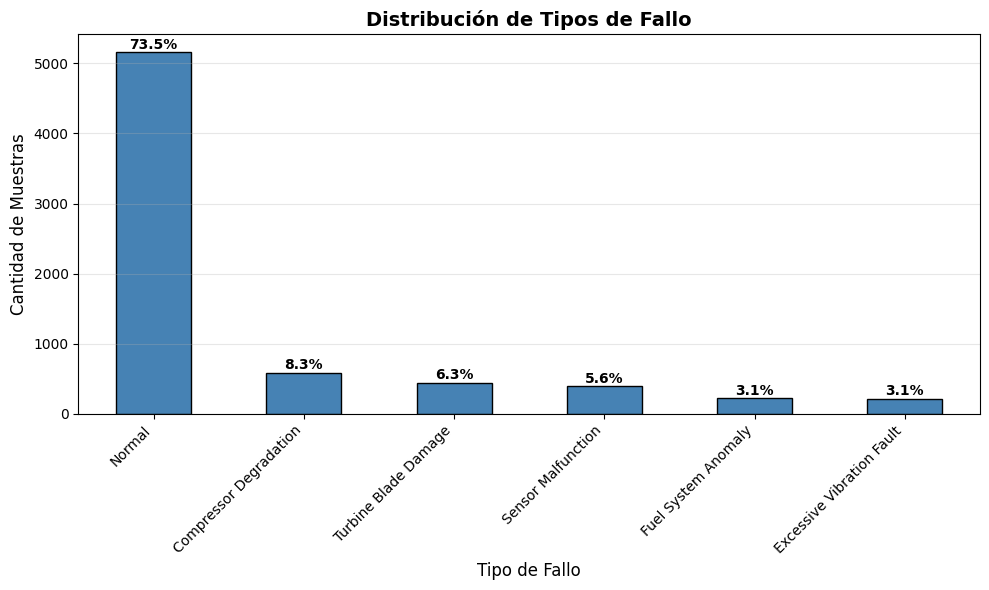


ESTADÍSTICAS DE DISTRIBUCIÓN DE CLASES:
Normal: 5157 muestras (73.55%)
Compressor Degradation: 584 muestras (8.33%)
Turbine Blade Damage: 444 muestras (6.33%)
Sensor Malfunction: 394 muestras (5.62%)
Fuel System Anomaly: 218 muestras (3.11%)
Excessive Vibration Fault: 215 muestras (3.07%)

Ratio de desbalanceo (mayor/menor): 23.99


In [26]:
# Distribución de clases
plt.figure(figsize=(10, 6))
fault_counts = df['Fault_Label'].value_counts()
ax = fault_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribución de Tipos de Fallo', fontsize=14, fontweight='bold')
plt.xlabel('Tipo de Fallo', fontsize=12)
plt.ylabel('Cantidad de Muestras', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Añadir porcentajes en las barras
for i, v in enumerate(fault_counts.values):
    percentage = (v / len(df)) * 100
    ax.text(i, v + 50, f'{percentage:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ESTADÍSTICAS DE DISTRIBUCIÓN DE CLASES:")
print("="*50)
for fault_type, count in fault_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{fault_type}: {count} muestras ({percentage:.2f}%)")

# Ratio de desbalanceo
min_class = fault_counts.min()
max_class = fault_counts.max()
imbalance_ratio = max_class / min_class
print(f"\nRatio de desbalanceo (mayor/menor): {imbalance_ratio:.2f}")

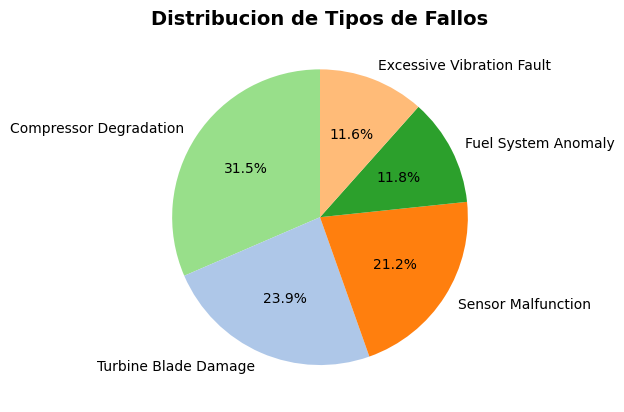

In [27]:
# distribucion de tipos de fallos
faults_dist = df_fallas['Fault_Label'].value_counts()
plt.pie(faults_dist.values, labels=faults_dist.index, autopct='%1.1f%%', startangle=90,
        colors=[color_map[f] for f in faults_dist.index])
plt.title('Distribucion de Tipos de Fallos', fontsize=14, fontweight='bold')
plt.show()

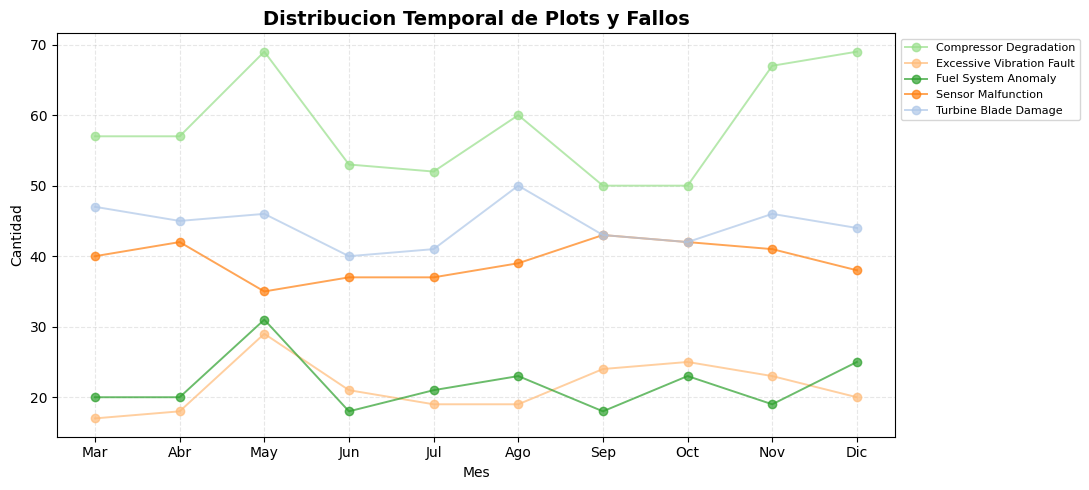

In [28]:
meses_num = sorted(df['month'].unique())
meses_nombres = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
meses_disp = [meses_nombres[m-1] for m in meses_num]

plt.figure(figsize=(12,5))

# linea x tipo de fallo
for fault, data in df_fallas.groupby('Fault_Label'):
    counts = data.groupby('month').size().reindex(meses_num, fill_value=0)
    plt.plot(meses_disp, counts.values, linewidth=1.4, alpha=0.7, label=fault,
             color=color_map[fault], marker='o')

plt.title('Distribucion Temporal de Plots y Fallos', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()


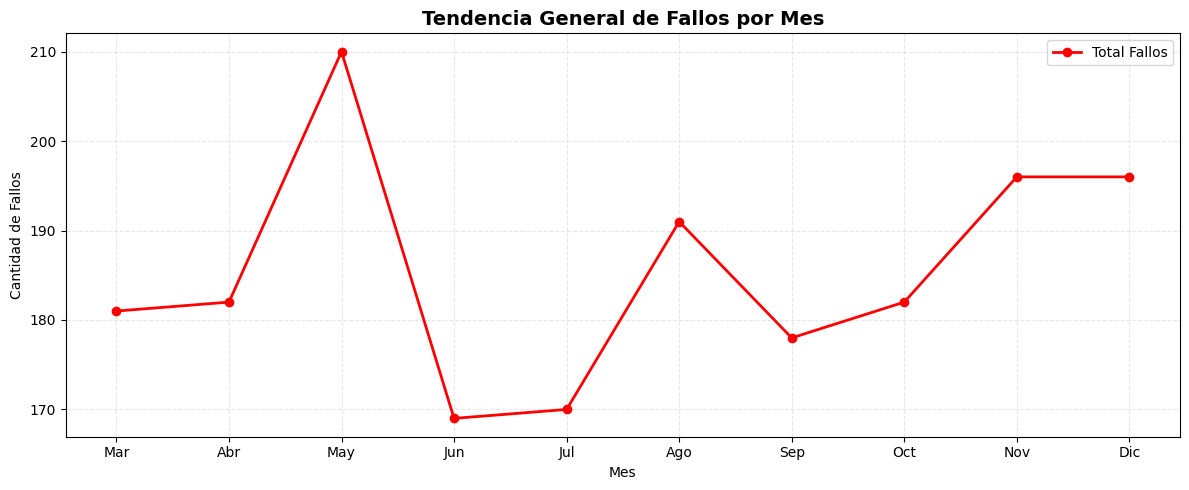

In [29]:
plt.figure(figsize=(12,5))

# contar todos los fallos por mes
total_fallos_mes = df_fallas.groupby('month').size().reindex(meses_num, fill_value=0)

# graficar tendencia general
plt.plot(meses_disp, total_fallos_mes.values, linewidth=2, color='red', marker='o', label='Total Fallos')

plt.title('Tendencia General de Fallos por Mes', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Fallos')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


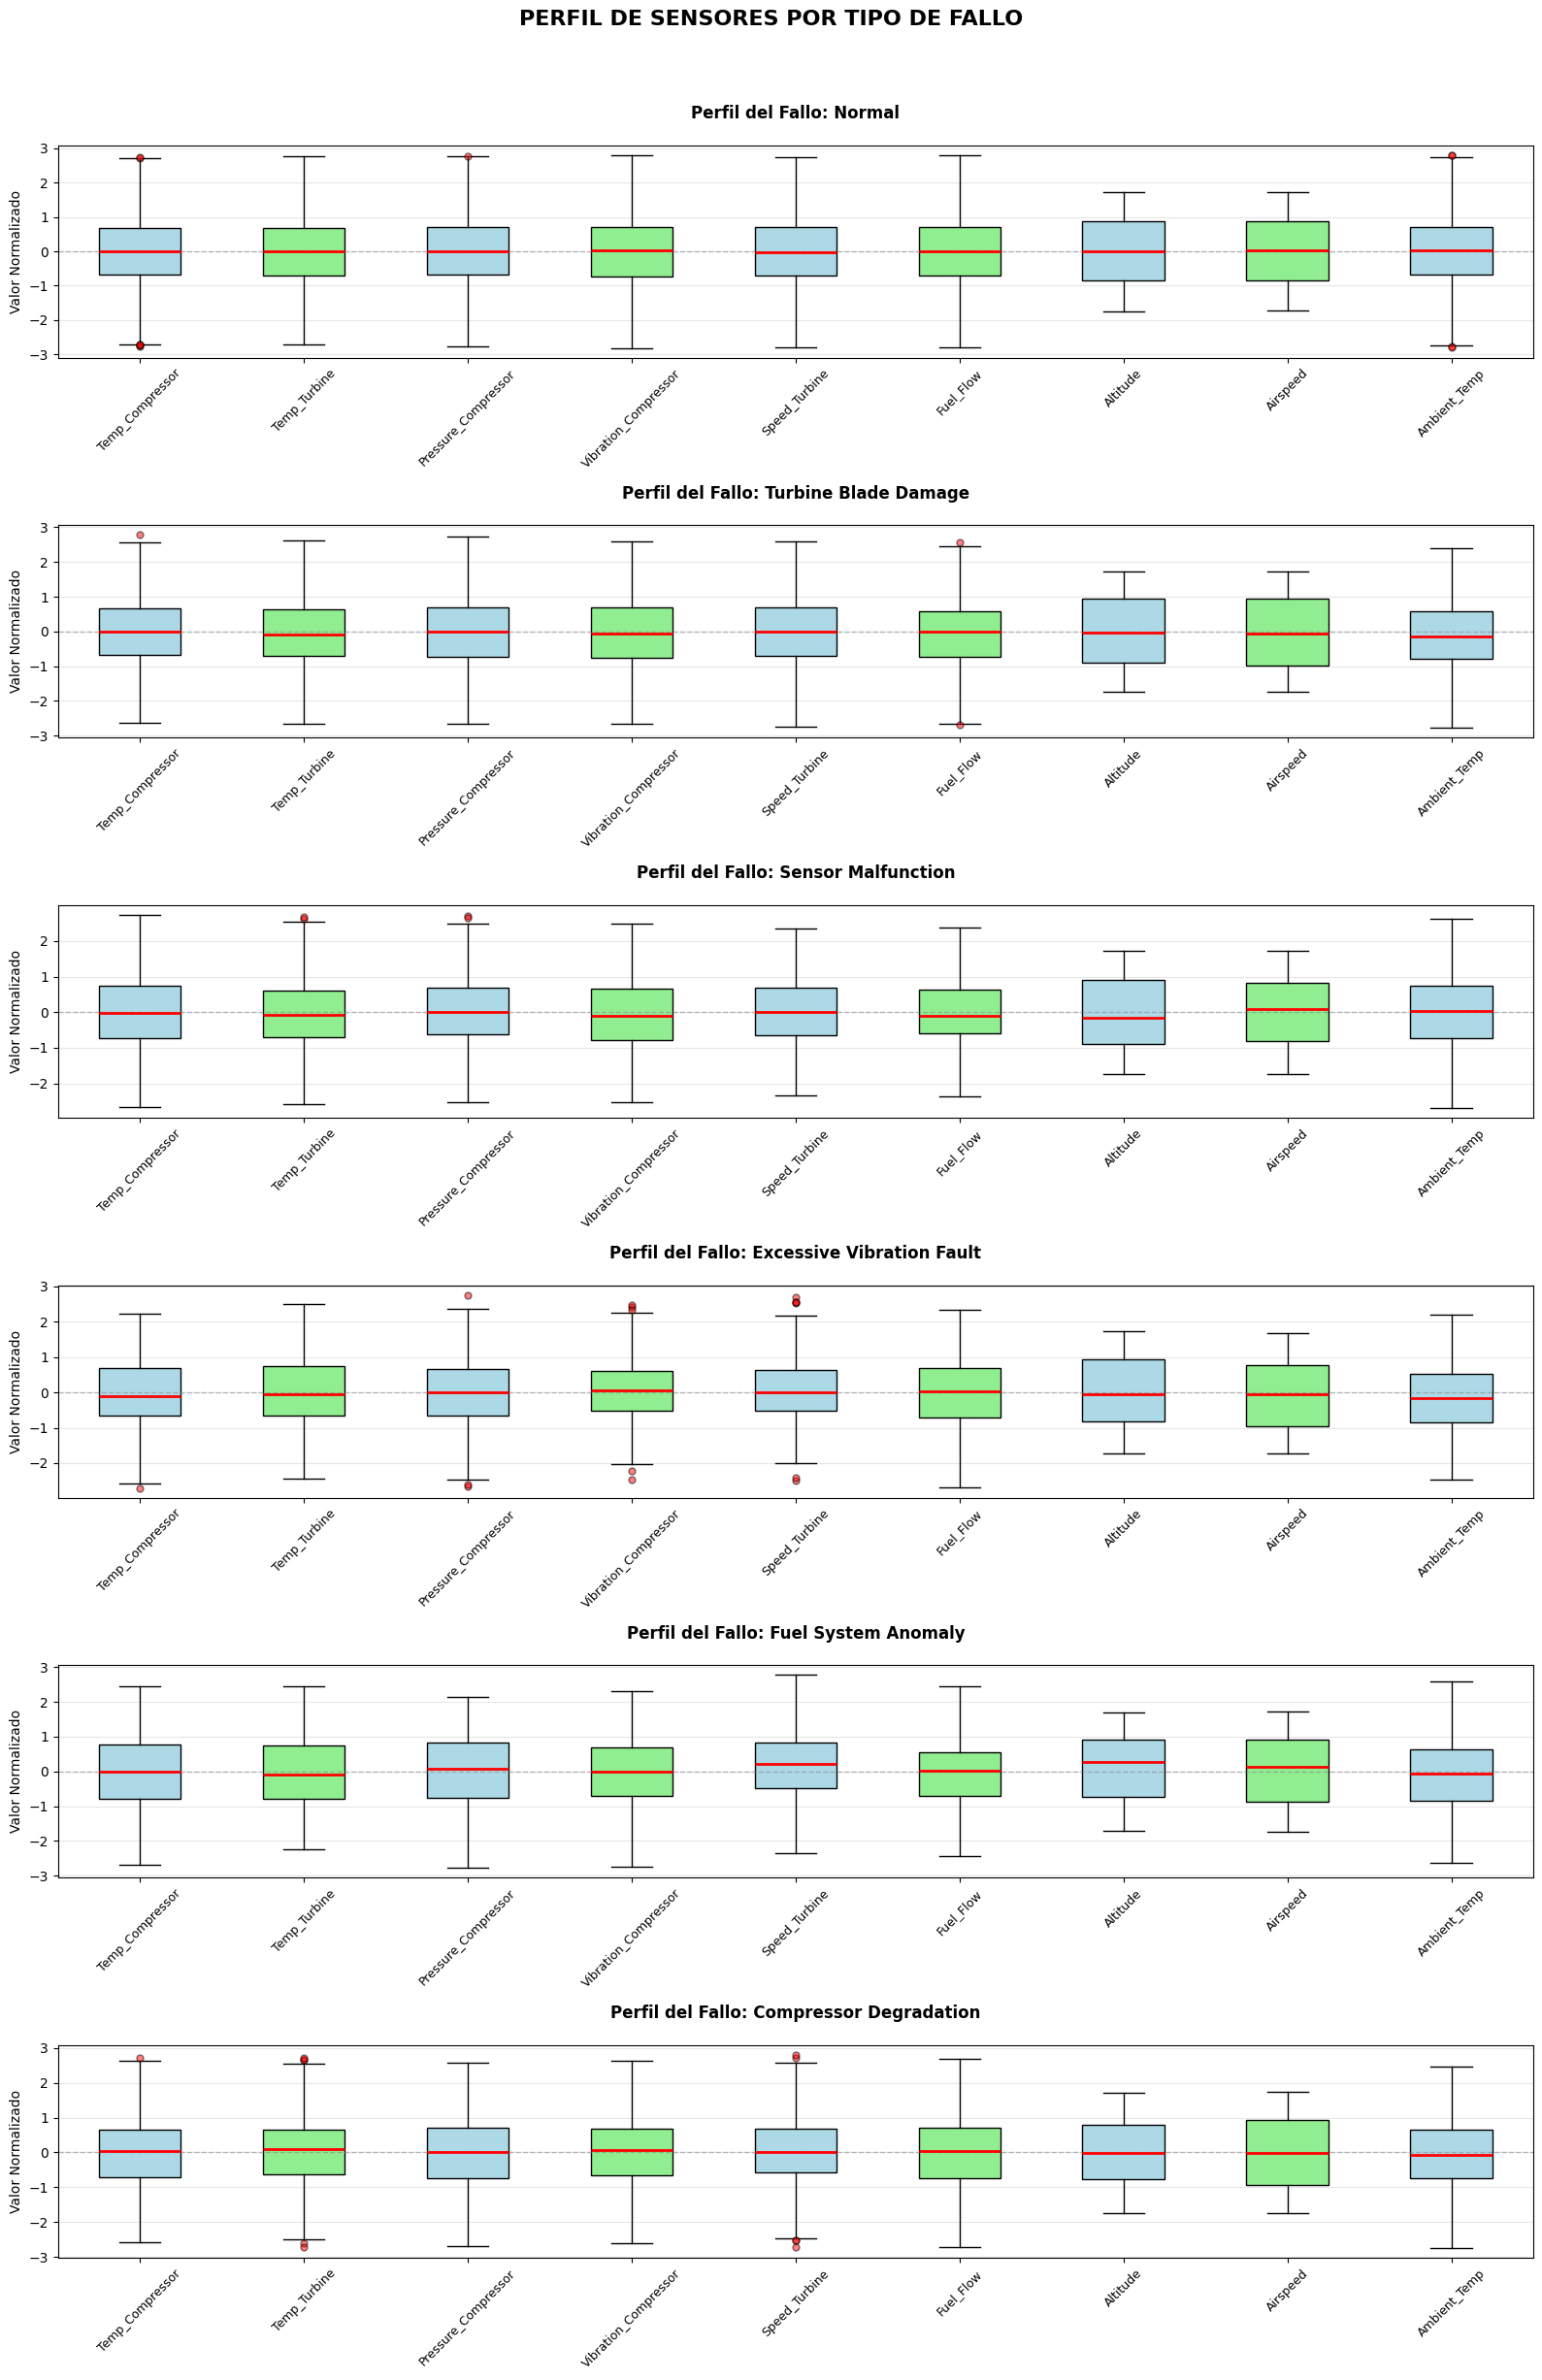

In [30]:
# Lista de tipos de fallo (excluyendo "Normal" si quieres solo fallos)
fallos = df['Fault_Label'].unique()
# Si quieres incluir Normal también:
# fallos = df['Fault_Label'].unique()

# Sensores principales para analizar (todos o selecciona los más importantes)
sensores_principales = ['Temp_Compressor', 'Temp_Turbine', 'Pressure_Compressor', 
                        'Vibration_Compressor', 'Speed_Turbine', 'Fuel_Flow', 
                        'Altitude', 'Airspeed', 'Ambient_Temp']

# Crear subplots: una fila por tipo de fallo
n_fallos = len(fallos)
fig, axes = plt.subplots(n_fallos, 1, figsize=(16, 4*n_fallos))

# Si solo hay un fallo, axes no es array
if n_fallos == 1:
    axes = [axes]

for idx, fallo in enumerate(fallos):
    ax = axes[idx]
    
    # Filtrar datos para este fallo
    df_fallo = df[df['Fault_Label'] == fallo]
    
    # Preparar datos para boxplot
    data_to_plot = [df_fallo[sensor].values for sensor in sensores_principales]
    
    # Crear boxplot
    box = ax.boxplot(data_to_plot, patch_artist=True, labels=sensores_principales,
                     medianprops=dict(color='red', linewidth=2),
                     boxprops=dict(facecolor='lightblue', color='black'),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
    
    # Colorear cajas alternadamente para mejor visualización
    colors = ['lightblue', 'lightgreen'] * (len(sensores_principales) // 2 + 1)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'Perfil del Fallo: {fallo}', fontsize=12, fontweight='bold', pad=20)
    ax.set_ylabel('Valor Normalizado', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Añadir línea en y=0 como referencia
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.suptitle('PERFIL DE SENSORES POR TIPO DE FALLO', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

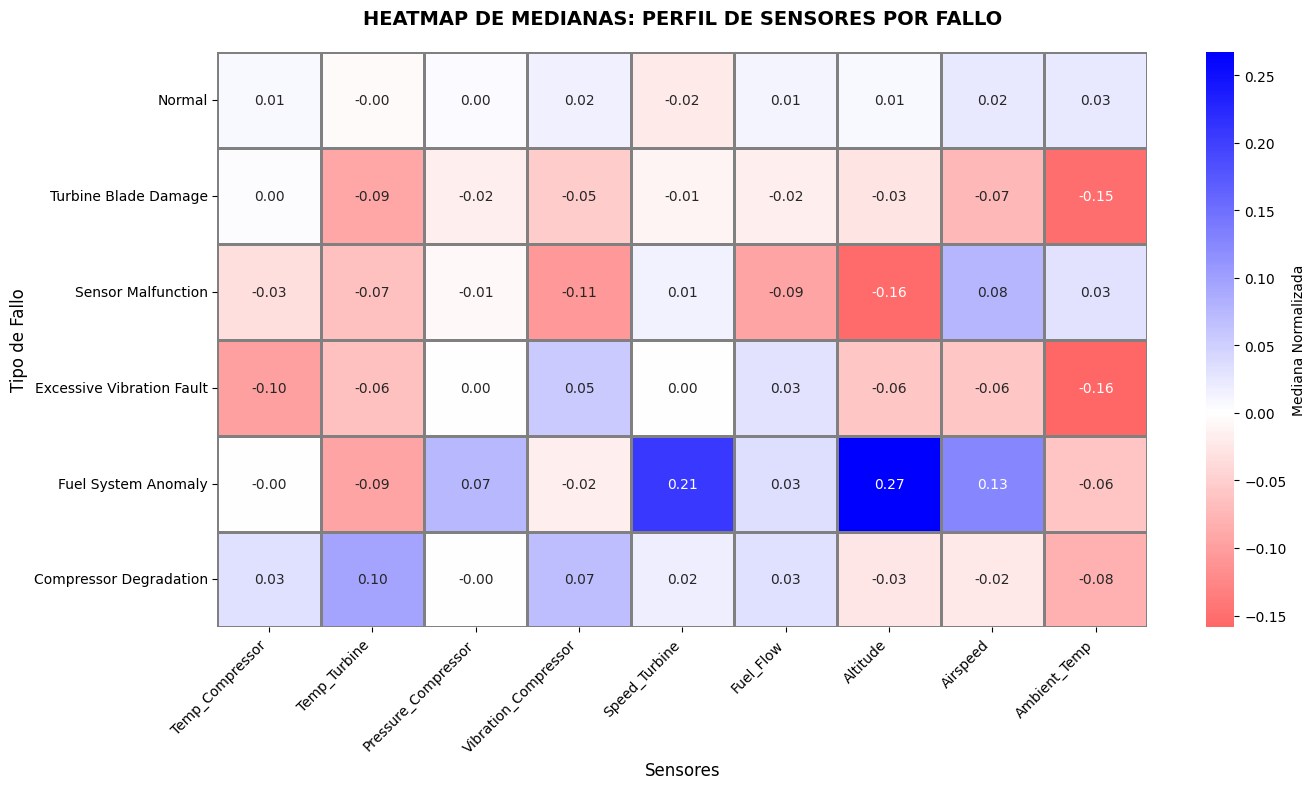


ANÁLISIS DE PATRONES POR FALLO:

🔍 Normal:
  Sensor más CARACTERÍSTICO: Ambient_Temp (0.03)

🔍 Turbine Blade Damage:
  Sensor más CARACTERÍSTICO: Ambient_Temp (-0.15)

🔍 Sensor Malfunction:
  Sensor más CARACTERÍSTICO: Altitude (-0.16)

🔍 Excessive Vibration Fault:
  Sensor más CARACTERÍSTICO: Ambient_Temp (-0.16)

🔍 Fuel System Anomaly:
  Sensor más CARACTERÍSTICO: Altitude (0.27)

🔍 Compressor Degradation:
  Sensor más CARACTERÍSTICO: Temp_Turbine (0.10)


In [31]:
# Heatmap de medianas - muestra patrones claramente
from matplotlib.colors import LinearSegmentedColormap

# Calcular medianas por fallo y sensor
median_matrix = pd.DataFrame(index=fallos, columns=sensores_principales)

for fallo in fallos:
    for sensor in sensores_principales:
        median_matrix.loc[fallo, sensor] = df[df['Fault_Label'] == fallo][sensor].median()

# Convertir a float
median_matrix = median_matrix.astype(float)

# Crear heatmap
plt.figure(figsize=(14, 8))

# Crear colormap personalizado (rojo-negativo, blanco-cero, azul-positivo)
cmap = LinearSegmentedColormap.from_list('my_cmap', ['red', 'white', 'blue'])

sns.heatmap(median_matrix, annot=True, fmt='.2f', cmap=cmap, center=0,
            linewidths=1, linecolor='gray', cbar_kws={'label': 'Mediana Normalizada'})

plt.title('HEATMAP DE MEDIANAS: PERFIL DE SENSORES POR FALLO', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Sensores', fontsize=12)
plt.ylabel('Tipo de Fallo', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis automático de patrones
print("\n" + "="*70)
print("ANÁLISIS DE PATRONES POR FALLO:")
print("="*70)

for fallo in fallos:
    print(f"\n🔍 {fallo}:")
    medians = median_matrix.loc[fallo]
    
    # Sensores más altos que el promedio
    altos = medians[medians > 0.5].sort_values(ascending=False)
    if len(altos) > 0:
        print(f"  Sensores ALTOS: {', '.join([f'{s}:{v:.2f}' for s,v in altos.items()])}")
    
    # Sensores más bajos que el promedio
    bajos = medians[medians < -0.5].sort_values()
    if len(bajos) > 0:
        print(f"  Sensores BAJOS: {', '.join([f'{s}:{v:.2f}' for s,v in bajos.items()])}")
    
    # Sensor más característico
    caracteristico = medians.abs().idxmax()
    print(f"  Sensor más CARACTERÍSTICO: {caracteristico} ({medians[caracteristico]:.2f})")

📊 Ejemplo 1: Comparando Normal vs Turbine Blade Damage


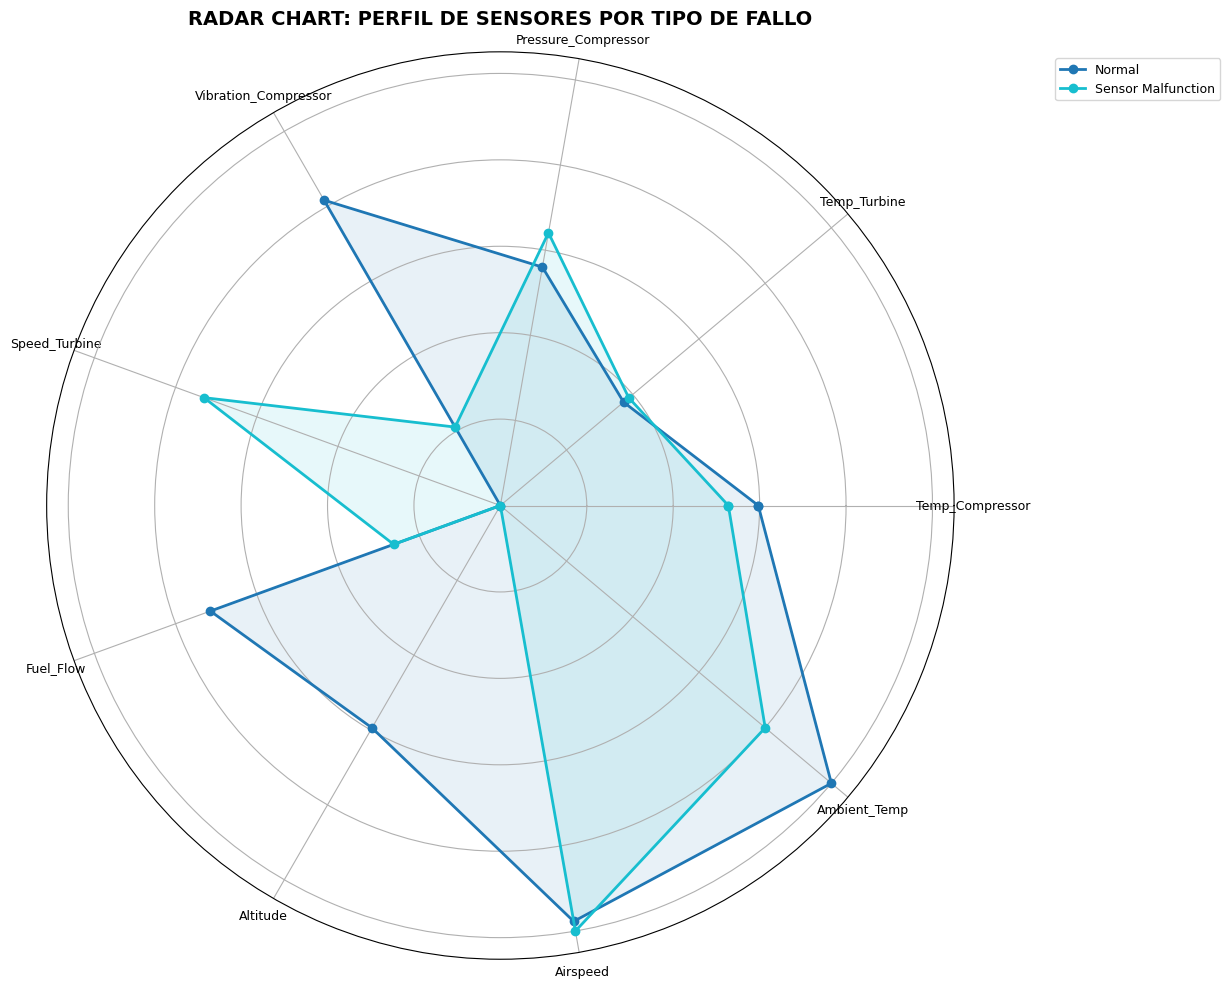


📊 Ejemplo 2: Comparando 3 fallos


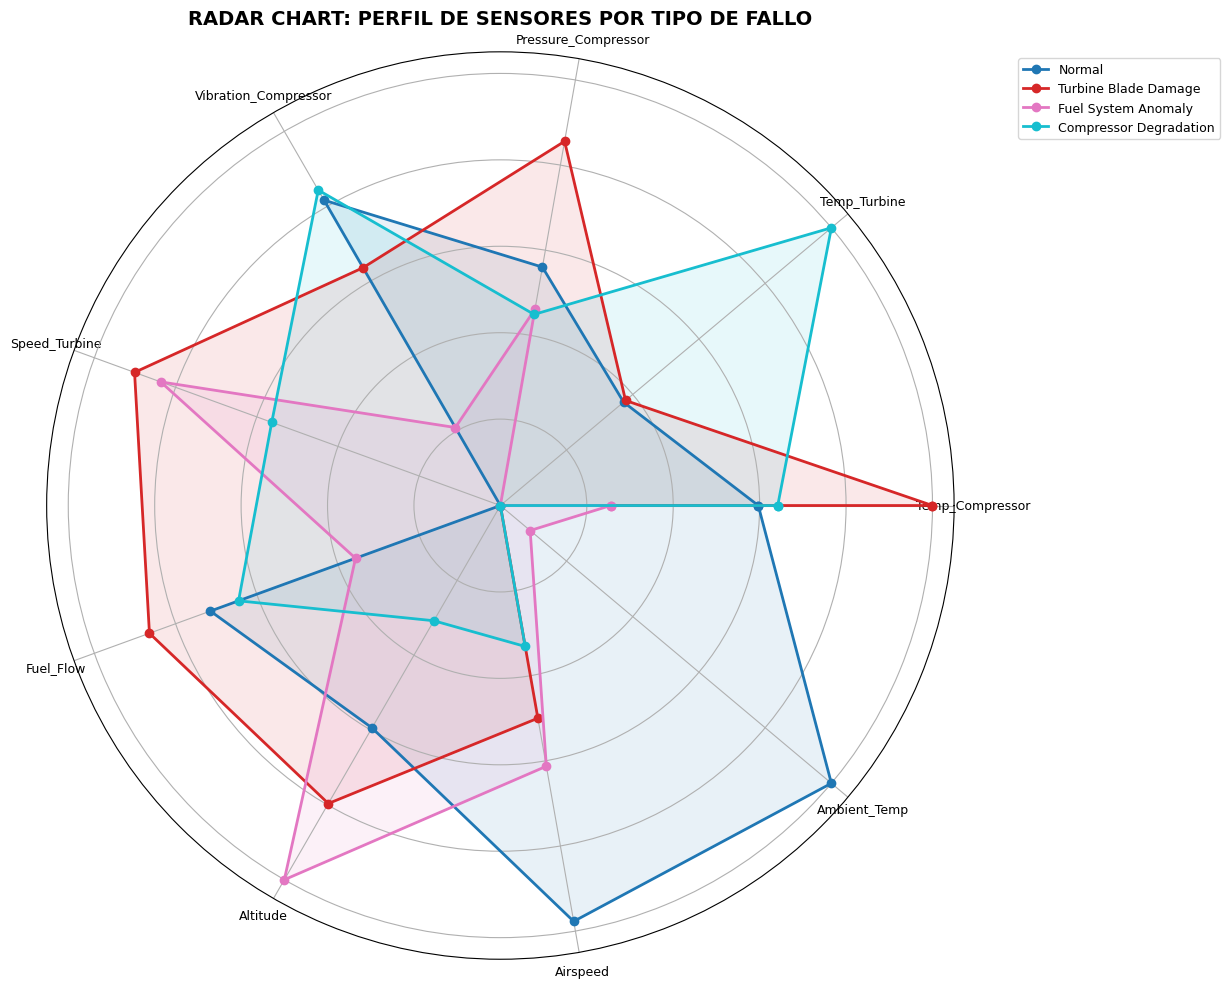

['Normal', 'Turbine Blade Damage', 'Sensor Malfunction', 'Excessive Vibration Fault', 'Fuel System Anomaly', 'Compressor Degradation']

📊 Ejemplo 3: Todos los fallos


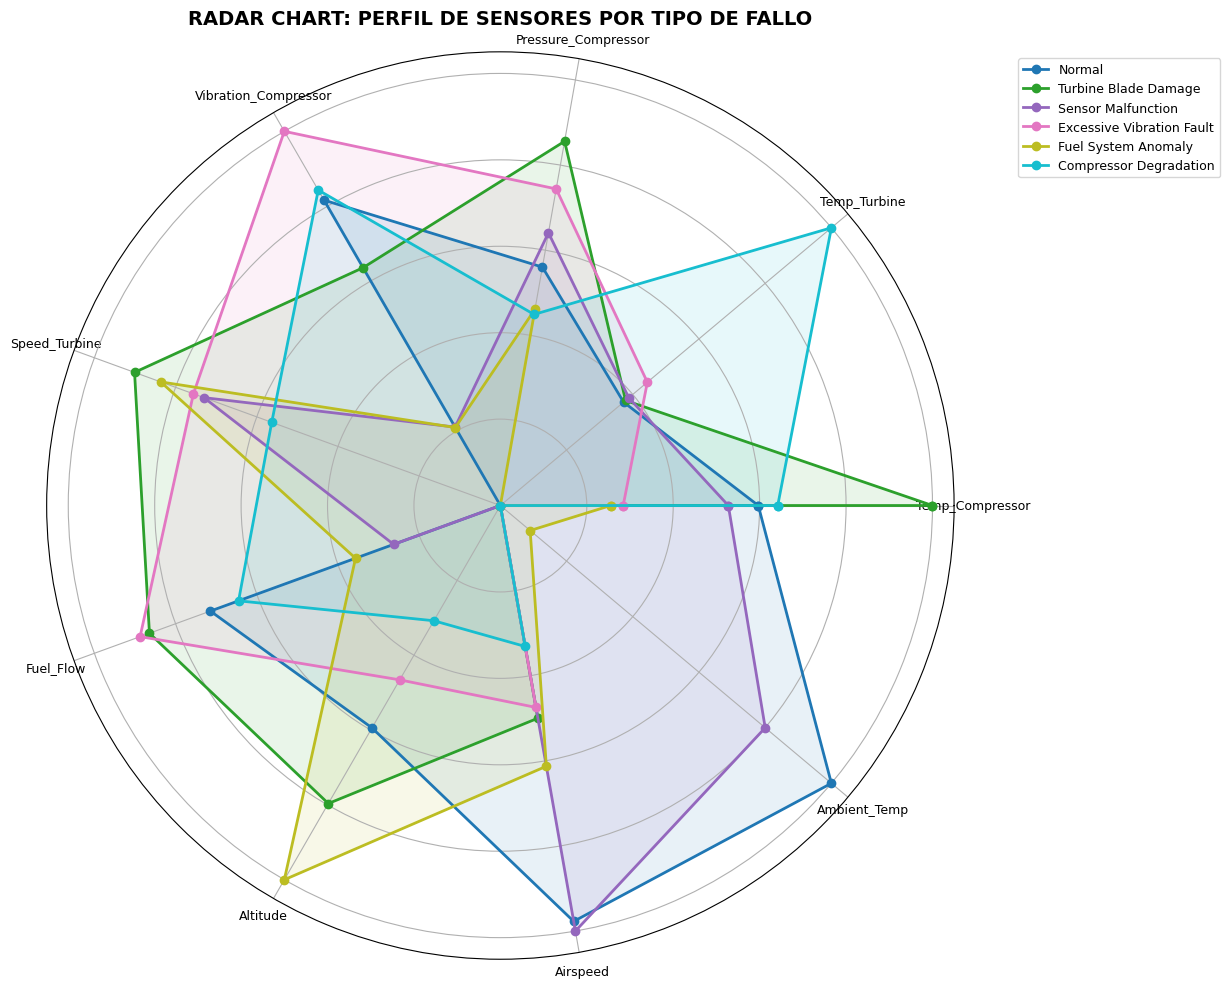

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Normalizar datos para radar chart
def normalize_for_radar(data):
    """Normalizar datos entre 0 y 1 para radar chart"""
    min_val = data.min()
    max_val = data.max()
    if max_val == min_val:
        return np.zeros_like(data)
    return (data - min_val) / (max_val - min_val)

# FUNCIÓN PARA RADAR PERSONALIZADO
def crear_radar_personalizado(fallos_a_comparar, median_matrix, sensores_principales):
    """
    Crea un radar chart con los fallos seleccionados
    
    Parameters:
    fallos_a_comparar: lista de nombres de fallos (ej: ['Normal', 'Turbine Blade Damage'])
    median_matrix: tu DataFrame con medianas por fallo
    sensores_principales: lista de sensores/columnas
    """
    # Verificar que los fallos existen
    fallos_disponibles = median_matrix.index.tolist()
    fallos_validos = []
    
    for fallo in fallos_a_comparar:
        if fallo in fallos_disponibles:
            fallos_validos.append(fallo)
        else:
            print(f"⚠️ Advertencia: '{fallo}' no encontrado. Fallos disponibles: {fallos_disponibles}")
    
    if not fallos_validos:
        print("❌ No hay fallos válidos para graficar")
        return
    
    # Crear radar chart
    fig = plt.figure(figsize=(14, 10))
    
    # Ángulos para cada sensor
    angles = np.linspace(0, 2*pi, len(sensores_principales), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo
    
    # Crear subplot polar
    ax = plt.subplot(111, polar=True)
    
    # Colores para cada fallo
    colors = plt.cm.tab10(np.linspace(0, 1, len(fallos_validos)))
    
    # Para cada fallo seleccionado, trazar una línea
    for idx, fallo in enumerate(fallos_validos):
        # Obtener medianas normalizadas
        valores = median_matrix.loc[fallo, sensores_principales].values
        valores_norm = normalize_for_radar(valores)
        valores_norm = np.concatenate((valores_norm, [valores_norm[0]]))  # Cerrar
        
        ax.plot(angles, valores_norm, 'o-', linewidth=2, label=fallo, color=colors[idx])
        ax.fill(angles, valores_norm, alpha=0.1, color=colors[idx])
    
    # Configurar el gráfico
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(sensores_principales, fontsize=9)
    ax.set_yticklabels([])
    ax.set_title('RADAR CHART: PERFIL DE SENSORES POR TIPO DE FALLO', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
    plt.tight_layout()
    plt.show()

# EJEMPLO 1: Solo Normal y Turbine Blade Damage
print("📊 Ejemplo 1: Comparando Normal vs Turbine Blade Damage")
crear_radar_personalizado(
    fallos_a_comparar=['Normal', 'Sensor Malfunction'],
    median_matrix=median_matrix,
    sensores_principales=sensores_principales
)

# EJEMPLO 2: Tres fallos específicos
print("\n📊 Ejemplo 2: Comparando 3 fallos")
crear_radar_personalizado(
    fallos_a_comparar=['Normal', 'Turbine Blade Damage', 'Fuel System Anomaly', 'Compressor Degradation'],
    median_matrix=median_matrix,
    sensores_principales=sensores_principales
)
print(todos_fallos)
# EJEMPLO 3: Todos los fallos
print("\n📊 Ejemplo 3: Todos los fallos")
todos_fallos = median_matrix.index.tolist()
crear_radar_personalizado(
    fallos_a_comparar=todos_fallos,
    median_matrix=median_matrix,
    sensores_principales=sensores_principales
)

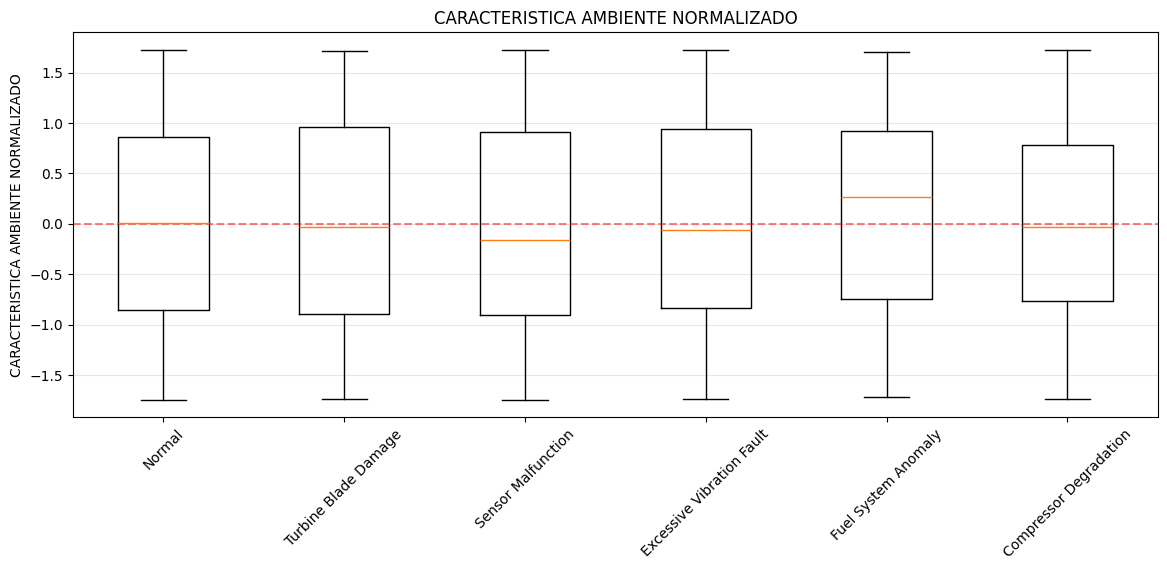

In [133]:
# Vamos a verificar esto gráficamente
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, figsize=(14, 5))

# 1. Ambient_Temp por tipo de fallo
box_data = [df[df['Fault_Label'] == fallo]['Altitude'].values 
            for fallo in df['Fault_Label'].unique()]

plt.boxplot(box_data, labels=df['Fault_Label'].unique())
plt.title("CARACTERISTICA AMBIENTE NORMALIZADO")
plt.ylabel("CARACTERISTICA AMBIENTE NORMALIZADO")
plt.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

In [34]:
# Análisis cuantitativo de lo que ves en el Radar Chart
print(f"\n{'='*70}")
print("ANÁLISIS CUANTITATIVO DEL RADAR CHART")
print(f"{'='*70}")

# Calcular métricas para cada fallo
for fallo in fallos:
    valores_norm = normalize_for_radar(median_matrix.loc[fallo].values)
    
    # 1. Área del polígono (aproximada)
    area = 0.5 * abs(sum(
        valores_norm[i] * valores_norm[(i+1) % len(valores_norm)] * 
        np.sin(angles[i+1] - angles[i])
        for i in range(len(valores_norm))
    ))
    
    # 2. Variabilidad (qué tan irregular es)
    std_val = np.std(valores_norm)
    
    # 3. Valor máximo (qué tan extremo es el fallo)
    max_val = np.max(valores_norm)
    sensor_max = sensores_principales[np.argmax(valores_norm)]
    
    # 4. Asimetría (si afecta sensores específicos)
    skewness = np.mean((valores_norm - np.mean(valores_norm))**3) / (std_val**3)
    
    print(f"\n🔍 {fallo}:")
    print(f"   Área del polígono: {area:.3f} {'(GRANDE)' if area > 0.3 else '(MEDIANA)' if area > 0.2 else '(PEQUEÑA)'}")
    print(f"   Variabilidad: {std_val:.3f} {'(ALTA)' if std_val > 0.3 else '(MEDIA)' if std_val > 0.2 else '(BAJA)'}")
    print(f"   Valor máximo: {max_val:.3f} en {sensor_max}")
    print(f"   Asimetría: {skewness:.3f} {'(ASIMÉTRICO)' if abs(skewness) > 0.5 else '(SIMÉTRICO)'}")


ANÁLISIS CUANTITATIVO DEL RADAR CHART

🔍 Normal:
   Área del polígono: 1.114 (GRANDE)
   Variabilidad: 0.292 (MEDIA)
   Valor máximo: 1.000 en Ambient_Temp
   Asimetría: -0.702 (ASIMÉTRICO)

🔍 Turbine Blade Damage:
   Área del polígono: 1.184 (GRANDE)
   Variabilidad: 0.301 (ALTA)
   Valor máximo: 1.000 en Temp_Compressor
   Asimetría: -0.980 (ASIMÉTRICO)

🔍 Sensor Malfunction:
   Área del polígono: 0.693 (GRANDE)
   Variabilidad: 0.301 (ALTA)
   Valor máximo: 1.000 en Airspeed
   Asimetría: -0.054 (SIMÉTRICO)

🔍 Excessive Vibration Fault:
   Área del polígono: 1.048 (GRANDE)
   Variabilidad: 0.297 (MEDIA)
   Valor máximo: 1.000 en Vibration_Compressor
   Asimetría: -0.297 (SIMÉTRICO)

🔍 Fuel System Anomaly:
   Área del polígono: 0.520 (GRANDE)
   Variabilidad: 0.318 (ALTA)
   Valor máximo: 1.000 en Altitude
   Asimetría: 0.477 (SIMÉTRICO)

🔍 Compressor Degradation:
   Área del polígono: 0.838 (GRANDE)
   Variabilidad: 0.283 (MEDIA)
   Valor máximo: 1.000 en Temp_Turbine
   Asimetría:

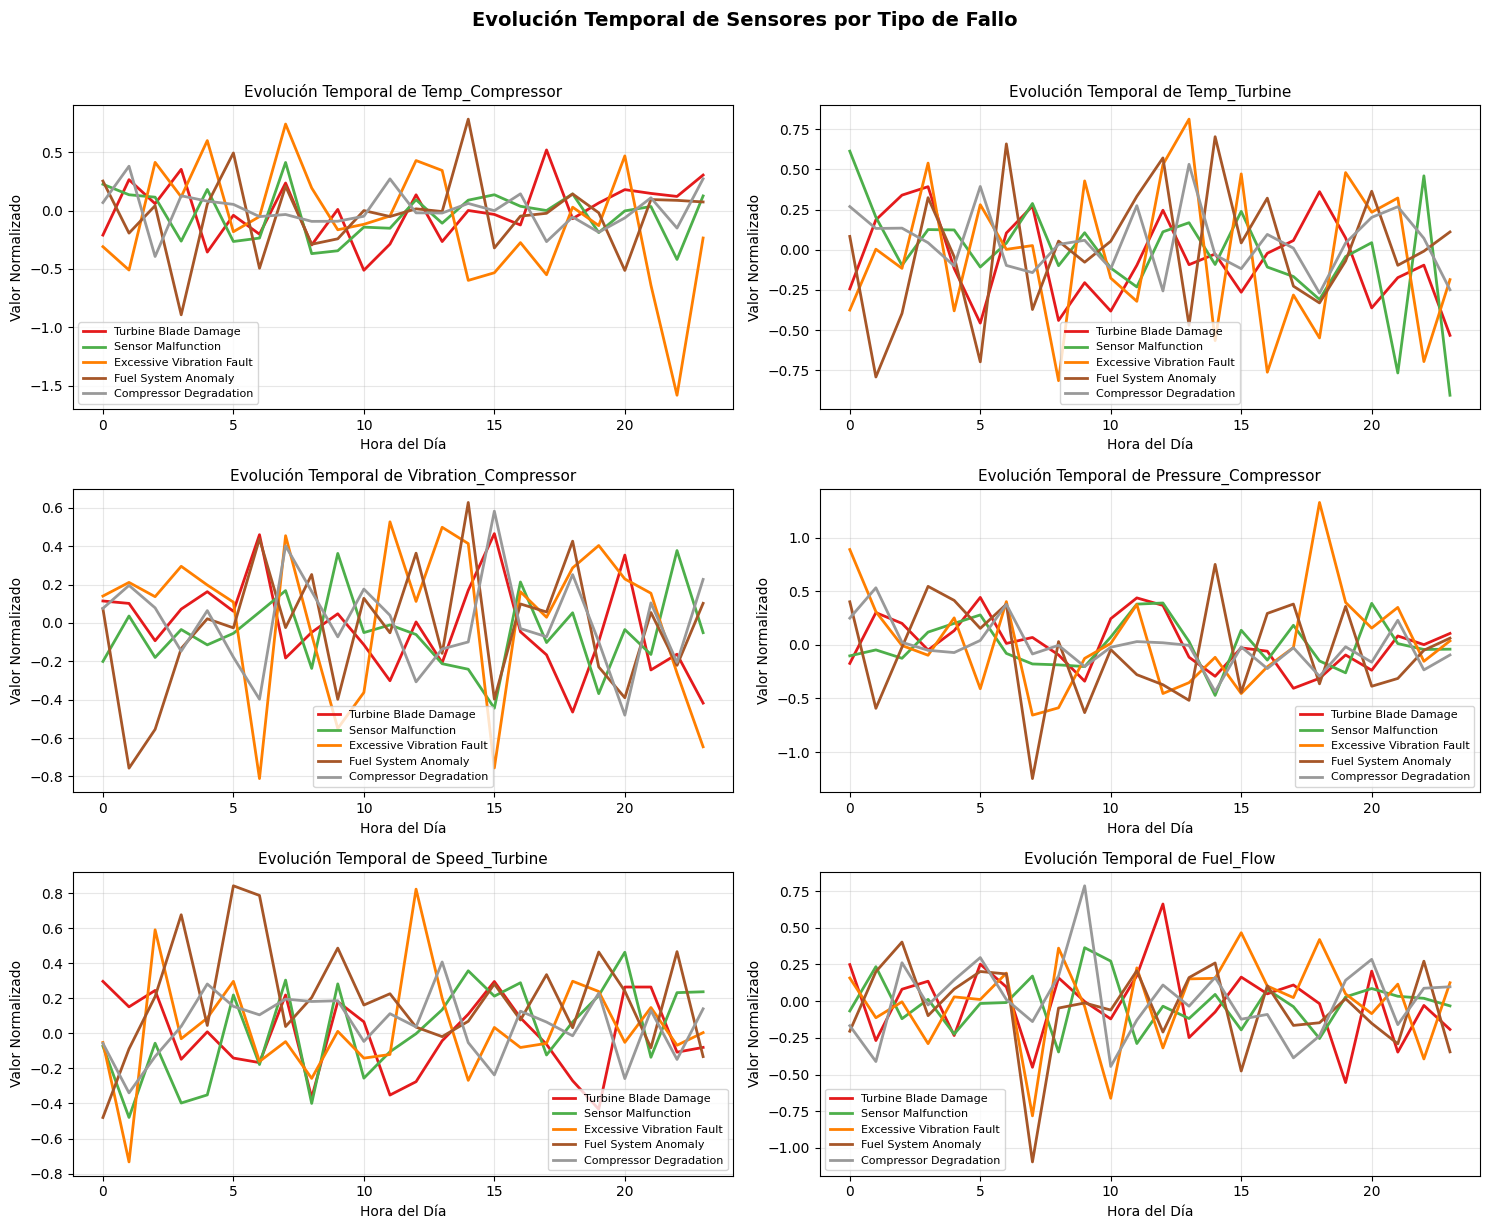

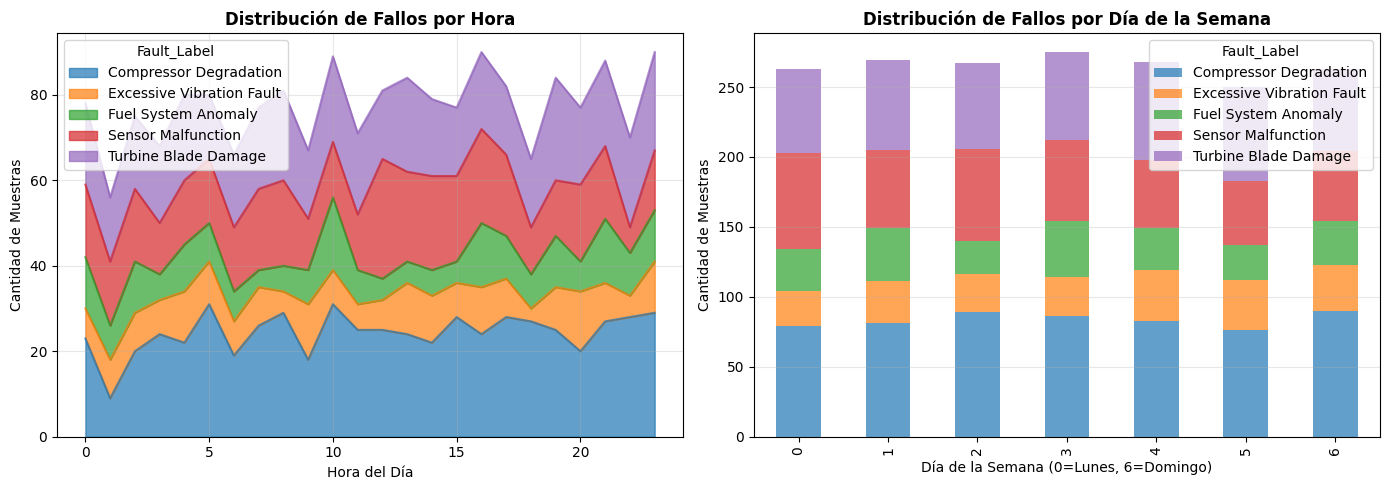

In [35]:
# Evolución temporal de sensores clave para cada tipo de fallo
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
sensors_to_plot = ['Temp_Compressor', 'Temp_Turbine', 'Vibration_Compressor', 
                   'Pressure_Compressor', 'Speed_Turbine', 'Fuel_Flow']
colors = plt.cm.Set1(np.linspace(0, 1, len(df_fallas['Fault_Label'].unique())))

for idx, sensor in enumerate(sensors_to_plot):
    ax = axes[idx//2, idx%2]
    for fault_type, color in zip(df_fallas['Fault_Label'].unique(), colors):
        subset = df_fallas[df_fallas['Fault_Label'] == fault_type]
        if len(subset) > 0:
            # Promedio por hora para suavizar
            hourly_avg = subset.groupby('hour')[sensor].mean()
            ax.plot(hourly_avg.index, hourly_avg.values, 
                   label=fault_type, color=color, linewidth=2)
    
    ax.set_title(f'Evolución Temporal de {sensor}', fontsize=11)
    ax.set_xlabel('Hora del Día')
    ax.set_ylabel('Valor Normalizado')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Evolución Temporal de Sensores por Tipo de Fallo', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Patrones diarios/semanales
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
hourly_faults = df_fallas.groupby(['hour', 'Fault_Label']).size().unstack()
hourly_faults.plot(kind='area', stacked=True, alpha=0.7, ax=plt.gca())
plt.title('Distribución de Fallos por Hora', fontweight='bold')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Muestras')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
daily_faults = df_fallas.groupby(['day_of_week', 'Fault_Label']).size().unstack()
daily_faults.plot(kind='bar', stacked=True, alpha=0.7, ax=plt.gca())
plt.title('Distribución de Fallos por Día de la Semana', fontweight='bold')
plt.xlabel('Día de la Semana (0=Lunes, 6=Domingo)')
plt.ylabel('Cantidad de Muestras')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Creación de Modelos

#### Preparación de Datos Para Modelado

In [36]:
# codificar la target variable
le = LabelEncoder()
df['Fault_Label_Encoded'] = le.fit_transform(df['Fault_Label'])

# mapeo de clases
print("\nMapeo de clases:")
for i, clase in enumerate(le.classes_):
    print(f"{i}: {clase}")

# separar caracteristicas y variable objetivo
X = df[numeric_cols]  # usamos todas las columnas numericas
y = df['Fault_Label_Encoded']

print(f"\nDimensiones de X: {X.shape}")
print(f"Distribucion de clases: {np.bincount(y)}")


Mapeo de clases:
0: Compressor Degradation
1: Excessive Vibration Fault
2: Fuel System Anomaly
3: Normal
4: Sensor Malfunction
5: Turbine Blade Damage

Dimensiones de X: (7012, 9)
Distribucion de clases: [ 584  215  218 5157  394  444]


In [37]:
# dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

print(f"Distribucion en entrenamiento: {np.bincount(y_train)}")
print(f"Distribucion en prueba: {np.bincount(y_test)}")

Conjunto de entrenamiento: (4908, 9)
Conjunto de prueba: (2104, 9)
Distribucion en entrenamiento: [ 409  150  152 3610  276  311]
Distribucion en prueba: [ 175   65   66 1547  118  133]


In [38]:
# estandarizar las caracteristicas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Estandarizacion completada")

Estandarizacion completada


#### Probar modelos tradicionales de Machine Learning

In [39]:
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre_modelo):
    """Función para evaluar y mostrar métricas de un modelo"""
    
    # entrenar modelo
    modelo.fit(X_train, y_train)
    
    # predecir
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test) if hasattr(modelo, "predict_proba") else None
    
    # metricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"RESULTADOS - {nombre_modelo}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # matriz de confusion
    print(f"\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # reporte de clasificacion
    print(f"\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return {
        'modelo': modelo,
        'accuracy': accuracy,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    

In [40]:
# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
resultados_rf = evaluar_modelo(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

RESULTADOS - Random Forest
Accuracy: 0.7353
F1-Score: 0.6231

Matriz de Confusión:
[[   0    0    0  175    0    0]
 [   0    0    0   65    0    0]
 [   0    0    0   66    0    0]
 [   0    0    0 1547    0    0]
 [   0    0    0  118    0    0]
 [   0    0    0  133    0    0]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       175
Excessive Vibration Fault       0.00      0.00      0.00        65
      Fuel System Anomaly       0.00      0.00      0.00        66
                   Normal       0.74      1.00      0.85      1547
       Sensor Malfunction       0.00      0.00      0.00       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.74      2104
                macro avg       0.12      0.17      0.14      2104
             weighted avg       0.54      0.74      0.62      2104



In [41]:
# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
resultados_gb = evaluar_modelo(gb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")

RESULTADOS - Gradient Boosting
Accuracy: 0.7224
F1-Score: 0.6178

Matriz de Confusión:
[[   0    0    2  172    1    0]
 [   0    0    1   64    0    0]
 [   0    0    0   66    0    0]
 [   3    5    8 1520    5    6]
 [   0    0    0  118    0    0]
 [   1    0    0  131    1    0]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       175
Excessive Vibration Fault       0.00      0.00      0.00        65
      Fuel System Anomaly       0.00      0.00      0.00        66
                   Normal       0.73      0.98      0.84      1547
       Sensor Malfunction       0.00      0.00      0.00       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.72      2104
                macro avg       0.12      0.16      0.14      2104
             weighted avg       0.54      0.72      0.62      2104



In [42]:
# 3. XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
resultados_xgb = evaluar_modelo(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost")

RESULTADOS - XGBoost
Accuracy: 0.7286
F1-Score: 0.6212

Matriz de Confusión:
[[   1    0    1  173    0    0]
 [   1    0    0   64    0    0]
 [   0    0    0   66    0    0]
 [   7    3    2 1532    1    2]
 [   0    0    0  118    0    0]
 [   1    0    0  132    0    0]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.10      0.01      0.01       175
Excessive Vibration Fault       0.00      0.00      0.00        65
      Fuel System Anomaly       0.00      0.00      0.00        66
                   Normal       0.73      0.99      0.84      1547
       Sensor Malfunction       0.00      0.00      0.00       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.73      2104
                macro avg       0.14      0.17      0.14      2104
             weighted avg       0.55      0.73      0.62      2104



In [43]:
# 4. SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
resultados_svm = evaluar_modelo(svm_model, X_train_scaled, X_test_scaled, y_train, y_test, "SVM")

RESULTADOS - SVM
Accuracy: 0.7353
F1-Score: 0.6231

Matriz de Confusión:
[[   0    0    0  175    0    0]
 [   0    0    0   65    0    0]
 [   0    0    0   66    0    0]
 [   0    0    0 1547    0    0]
 [   0    0    0  118    0    0]
 [   0    0    0  133    0    0]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       175
Excessive Vibration Fault       0.00      0.00      0.00        65
      Fuel System Anomaly       0.00      0.00      0.00        66
                   Normal       0.74      1.00      0.85      1547
       Sensor Malfunction       0.00      0.00      0.00       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.74      2104
                macro avg       0.12      0.17      0.14      2104
             weighted avg       0.54      0.74      0.62      2104



In [44]:
# 5. Regresion Logistica
lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
resultados_lr = evaluar_modelo(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Regresión Logística")

RESULTADOS - Regresión Logística
Accuracy: 0.7353
F1-Score: 0.6231

Matriz de Confusión:
[[   0    0    0  175    0    0]
 [   0    0    0   65    0    0]
 [   0    0    0   66    0    0]
 [   0    0    0 1547    0    0]
 [   0    0    0  118    0    0]
 [   0    0    0  133    0    0]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       175
Excessive Vibration Fault       0.00      0.00      0.00        65
      Fuel System Anomaly       0.00      0.00      0.00        66
                   Normal       0.74      1.00      0.85      1547
       Sensor Malfunction       0.00      0.00      0.00       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.74      2104
                macro avg       0.12      0.17      0.14      2104
             weighted avg       0.54      0.74      0.62      2104



#### Probar modelos de Deep Learning

In [45]:
# definir arquitectura de la red neuronal
modelo_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

W0000 00:00:1764776968.143458    1303 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [46]:
# compilar el modelo
modelo_nn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
print("Arquitectura del modelo:")
modelo_nn.summary()

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350 (13.09 KB)

 Trainable params: 3,350 (13.09 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# entrenar la red neuronal
history = modelo_nn.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7226 - loss: 1.1331 - val_accuracy: 0.7322 - val_loss: 1.0153 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 1.0414 - val_accuracy: 0.7322 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 1.0240 - val_accuracy: 0.7322 - val_loss: 1.0060 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 1.0185 - val_accuracy: 0.7322 - val_loss: 1.0083 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 1.0140 - val_accuracy: 0.7322 - val_loss: 1.0084 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 1.0028 - val_accuracy: 0.7322 - val_loss: 1.0071 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 1.

## Evaluación y Optimización de Modelos

### Evaluación

##### Modelos clásicos

In [49]:
resultados = {
    'Random Forest': resultados_rf,
    'Gradient Boosting': resultados_gb,
    'XGBoost': resultados_xgb,
    'SVM': resultados_svm,
    'Regresión Logística': resultados_lr
}

In [50]:
comparacion = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Accuracy': [resultados[modelo]['accuracy'] for modelo in resultados],
    'F1-Score': [resultados[modelo]['f1_score'] for modelo in resultados]
}).sort_values('Accuracy', ascending=False)

In [51]:
comparacion

,Modelo,Accuracy,F1-Score
0,Random Forest,0.735266,0.623093
4,Regresión Logística,0.735266,0.623093
3,SVM,0.735266,0.623093
2,XGBoost,0.728612,0.621179
1,Gradient Boosting,0.722433,0.617802


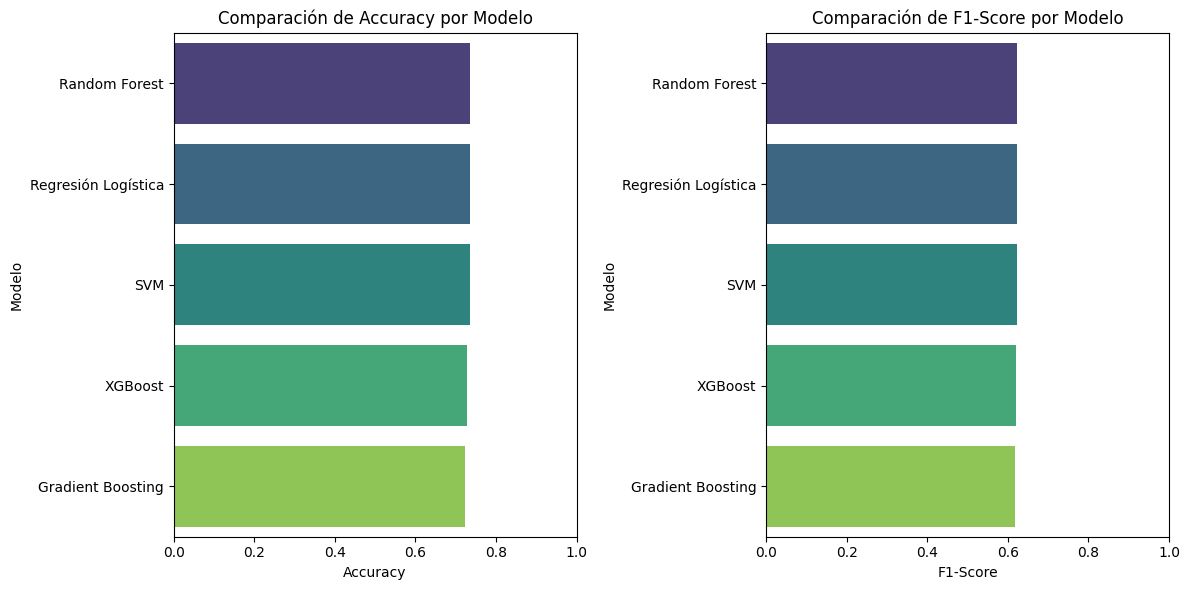

In [52]:
plt.figure(figsize=(12, 6))

# grafico de accuracy
plt.subplot(1, 2, 1)
sns.barplot(data=comparacion, x='Accuracy', y='Modelo', palette='viridis')
plt.title('Comparación de Accuracy por Modelo')
plt.xlim(0, 1)

# grafico de F1-Score
plt.subplot(1, 2, 2)
sns.barplot(data=comparacion, x='F1-Score', y='Modelo', palette='viridis')
plt.title('Comparación de F1-Score por Modelo')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

##### Deep Learning

In [53]:
y_pred_nn = modelo_nn.predict(X_test_scaled)
y_pred_nn_class = np.argmax(y_pred_nn, axis=1)

accuracy_nn = accuracy_score(y_test, y_pred_nn_class)
f1_nn = f1_score(y_test, y_pred_nn_class, average='weighted')

print(f"\n{'='*50}")
print("RESULTADOS - RED NEURONAL")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")

print(f"\nMatriz de Confusion:")
print(confusion_matrix(y_test, y_pred_nn_class))

print(f"\nReporte de Clasificacion:")
print(classification_report(y_test, y_pred_nn_class, target_names=le.classes_))

# añadir a la comparacion
resultados_nn = {
    'accuracy': accuracy_nn,
    'f1_score': f1_nn
}

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step

RESULTADOS - RED NEURONAL
Accuracy: 0.7353
F1-Score: 0.6231

Matriz de Confusion:
[[   0    0    0  175    0    0]
 [   0    0    0   65    0    0]
 [   0    0    0   66    0    0]
 [   0    0    0 1547    0    0]
 [   0    0    0  118    0    0]
 [   0    0    0  133    0    0]]

Reporte de Clasificacion:
                           precision    recall  f1-score   support

   Compressor Degradation       0.00      0.00      0.00       175
Excessive Vibration Fault       0.00      0.00      0.00        65
      Fuel System Anomaly       0.00      0.00      0.00        66
                   Normal       0.74      1.00      0.85      1547
       Sensor Malfunction       0.00      0.00      0.00       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.74      2104
                macro avg       0.12      0.17      0.14      2104
             weighted avg       0.54      0.7

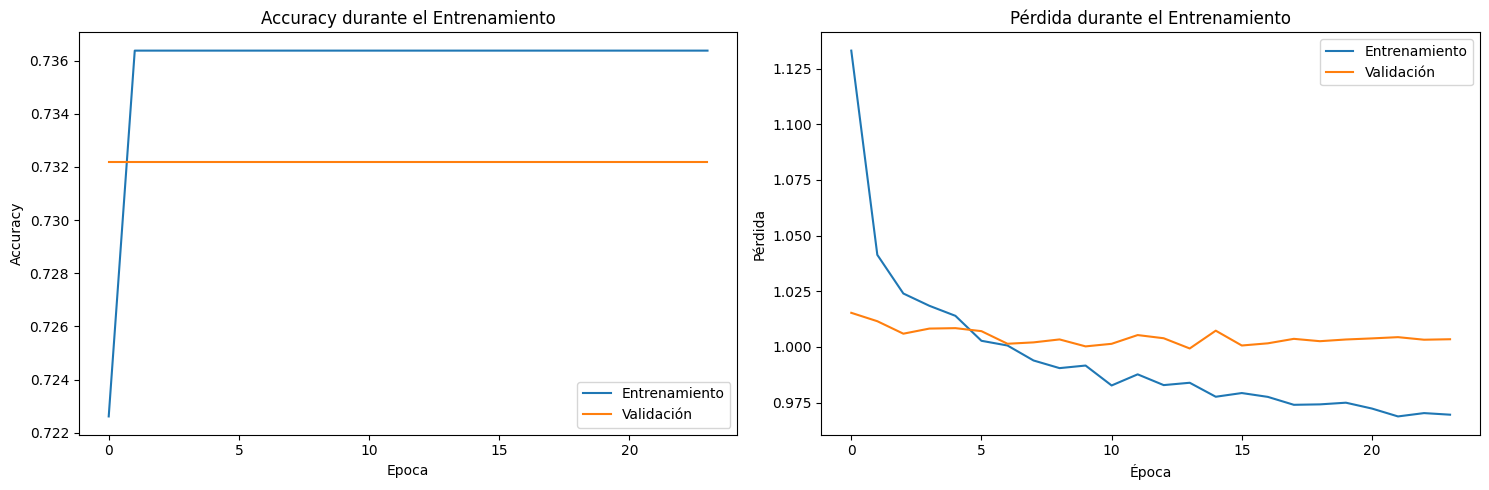

In [54]:
# visualizar el entrenamiento de la red neuronal
plt.figure(figsize=(15, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

### Optimización de Modelos: SMOTE

Debido al notorio desbalance entre las clases de los fallos, vamos a llevar a cabo un procceso de Oversampling o Generación de Datos Sintéticos para clases minoritarias. Esto lo vamos a hacer mediante la técnica de SMOTE (Synthetic Minority Over-sampling Technique), que genera nuevos ejemplos interpolando entre puntos existentes de las clases minoritarias.

Solo aplicamos SMOTE al conjunto de entrenamiento, no al de prueba.

In [55]:
print(f"Distribucion original: {Counter(y_train)}")

# crear el generador SMOTE
smote = SMOTE(random_state=42)

# aplicar SMOTE al conjunto de entrenamiento
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ver nueva distribucion
print(f"Distribucion despues de SMOTE: {Counter(y_train_res)}")

Distribucion original: Counter({3: 3610, 0: 409, 5: 311, 4: 276, 2: 152, 1: 150})
Distribucion despues de SMOTE: Counter({3: 3610, 5: 3610, 0: 3610, 1: 3610, 4: 3610, 2: 3610})


In [56]:
# estandarizar las caracteristicas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("Estandarizacion completada")

Estandarizacion completada


#### Modelos Clásicos

In [57]:
# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
resultados_rf = evaluar_modelo(rf_model, X_train_scaled, X_test_scaled, y_train_res, y_test, "Random Forest")

RESULTADOS - Random Forest
Accuracy: 0.5751
F1-Score: 0.5629

Matriz de Confusión:
[[  11    5    7  132   12    8]
 [   2    5    2   50    1    5]
 [   3    3    1   54    4    1]
 [ 106   55   47 1184   86   69]
 [   4    7    4   93    5    5]
 [  10    8    3  107    1    4]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.08      0.06      0.07       175
Excessive Vibration Fault       0.06      0.08      0.07        65
      Fuel System Anomaly       0.02      0.02      0.02        66
                   Normal       0.73      0.77      0.75      1547
       Sensor Malfunction       0.05      0.04      0.04       118
     Turbine Blade Damage       0.04      0.03      0.04       133

                 accuracy                           0.58      2104
                macro avg       0.16      0.17      0.16      2104
             weighted avg       0.55      0.58      0.56      2104



In [58]:
# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
resultados_gb = evaluar_modelo(gb_model, X_train_scaled, X_test_scaled, y_train_res, y_test, "Gradient Boosting")

RESULTADOS - Gradient Boosting
Accuracy: 0.2357
F1-Score: 0.3122

Matriz de Confusión:
[[ 24  28  24  52  23  24]
 [ 13   7   9  23   5   8]
 [  6   9  11  19  10  11]
 [212 253 235 422 193 232]
 [ 10  27  16  26  14  25]
 [ 20  28   9  40  18  18]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.08      0.14      0.10       175
Excessive Vibration Fault       0.02      0.11      0.03        65
      Fuel System Anomaly       0.04      0.17      0.06        66
                   Normal       0.73      0.27      0.40      1547
       Sensor Malfunction       0.05      0.12      0.07       118
     Turbine Blade Damage       0.06      0.14      0.08       133

                 accuracy                           0.24      2104
                macro avg       0.16      0.16      0.12      2104
             weighted avg       0.55      0.24      0.31      2104



In [59]:
# 3. XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
resultados_xgb = evaluar_modelo(xgb_model, X_train_scaled, X_test_scaled, y_train_res, y_test, "XGBoost")

RESULTADOS - XGBoost
Accuracy: 0.4363
F1-Score: 0.4848

Matriz de Confusión:
[[ 22   8   7 101  14  23]
 [ 12   6   2  33   6   6]
 [  3   8   3  38   7   7]
 [182 104  89 864 163 145]
 [ 11  12   4  64  11  16]
 [ 14  13   0  85   9  12]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.09      0.13      0.11       175
Excessive Vibration Fault       0.04      0.09      0.06        65
      Fuel System Anomaly       0.03      0.05      0.04        66
                   Normal       0.73      0.56      0.63      1547
       Sensor Malfunction       0.05      0.09      0.07       118
     Turbine Blade Damage       0.06      0.09      0.07       133

                 accuracy                           0.44      2104
                macro avg       0.17      0.17      0.16      2104
             weighted avg       0.55      0.44      0.48      2104



In [60]:
# 4. SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
resultados_svm = evaluar_modelo(svm_model, X_train_scaled, X_test_scaled, y_train_res, y_test, "SVM")

RESULTADOS - SVM
Accuracy: 0.3075
F1-Score: 0.3812

Matriz de Confusión:
[[ 30  14  12  71  22  26]
 [ 13  10   4  28   6   4]
 [ 13   5   4  24  13   7]
 [281 151 143 572 194 206]
 [ 17  15  11  43  17  15]
 [ 24  15  13  54  13  14]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.08      0.17      0.11       175
Excessive Vibration Fault       0.05      0.15      0.07        65
      Fuel System Anomaly       0.02      0.06      0.03        66
                   Normal       0.72      0.37      0.49      1547
       Sensor Malfunction       0.06      0.14      0.09       118
     Turbine Blade Damage       0.05      0.11      0.07       133

                 accuracy                           0.31      2104
                macro avg       0.16      0.17      0.14      2104
             weighted avg       0.55      0.31      0.38      2104



In [61]:
# 5. Regresion Logistica
lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
resultados_lr = evaluar_modelo(lr_model, X_train_scaled, X_test_scaled, y_train_res, y_test, "Regresión Logística")

RESULTADOS - Regresión Logística
Accuracy: 0.1464
F1-Score: 0.2041

Matriz de Confusión:
[[ 23  38  43  29  26  16]
 [  8   9  16   8  14  10]
 [ 11  13  15  10  14   3]
 [215 252 378 237 287 178]
 [ 12  22  39  21  13  11]
 [ 22  33  28  20  19  11]]

Reporte de Clasificación:
                           precision    recall  f1-score   support

   Compressor Degradation       0.08      0.13      0.10       175
Excessive Vibration Fault       0.02      0.14      0.04        65
      Fuel System Anomaly       0.03      0.23      0.05        66
                   Normal       0.73      0.15      0.25      1547
       Sensor Malfunction       0.03      0.11      0.05       118
     Turbine Blade Damage       0.05      0.08      0.06       133

                 accuracy                           0.15      2104
                macro avg       0.16      0.14      0.09      2104
             weighted avg       0.55      0.15      0.20      2104



#### Modelos de Deep Learning

In [62]:
# definir arquitectura de la red neuronal
modelo_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

In [63]:
# compilar el modelo
modelo_nn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [64]:
print("Arquitectura del modelo:")
modelo_nn.summary()

Arquitectura del modelo:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350 (13.09 KB)

 Trainable params: 3,350 (13.09 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# entrenar la red neuronal
history = modelo_nn.fit(
    X_train_scaled, y_train_res,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

Epoch 1/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2446 - loss: 1.6715 - val_accuracy: 0.0000e+00 - val_loss: 3.2846 - learning_rate: 0.0010
Epoch 2/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.3040 - loss: 1.6087 - val_accuracy: 0.0069 - val_loss: 3.2073 - learning_rate: 0.0010
Epoch 3/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.3405 - loss: 1.5678 - val_accuracy: 0.0129 - val_loss: 3.3746 - learning_rate: 0.0010
Epoch 4/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.3576 - loss: 1.5349 - val_accuracy: 0.0302 - val_loss: 3.3139 - learning_rate: 0.0010
Epoch 5/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.3767 - loss: 1.5019 - val_accuracy: 0.0289 - val_loss: 3.1912 - learning_rate: 0.0010
Epoch 6/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.3867 - loss: 1.4816 - val_accuracy: 0.0279 - val_loss: 3.3414 - learning_rate: 0.0010
Epoch 7/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0

### Evaluación

##### Modelos Clásicos

In [66]:
resultados = {
    'Random Forest': resultados_rf,
    'Gradient Boosting': resultados_gb,
    'XGBoost': resultados_xgb,
    'SVM': resultados_svm,
    'Regresión Logística': resultados_lr
}

In [67]:
comparacion = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Accuracy': [resultados[modelo]['accuracy'] for modelo in resultados],
    'F1-Score': [resultados[modelo]['f1_score'] for modelo in resultados]
}).sort_values('Accuracy', ascending=False)

In [68]:
comparacion

,Modelo,Accuracy,F1-Score
0,Random Forest,0.575095,0.562938
2,XGBoost,0.436312,0.484808
3,SVM,0.307510,0.381229
1,Gradient Boosting,0.235741,0.312231
4,Regresión Logística,0.146388,0.204091


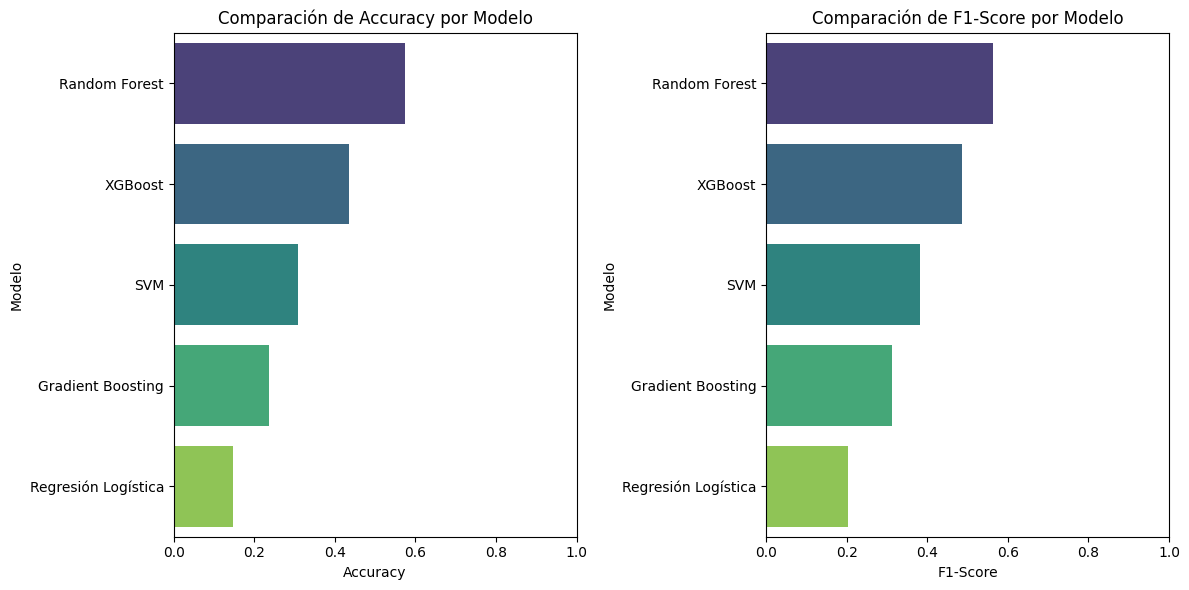

In [69]:
plt.figure(figsize=(12, 6))

# grafico de accuracy
plt.subplot(1, 2, 1)
sns.barplot(data=comparacion, x='Accuracy', y='Modelo', palette='viridis')
plt.title('Comparación de Accuracy por Modelo')
plt.xlim(0, 1)

# grafico de F1-Score
plt.subplot(1, 2, 2)
sns.barplot(data=comparacion, x='F1-Score', y='Modelo', palette='viridis')
plt.title('Comparación de F1-Score por Modelo')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

##### Modelos de Deep Learning

In [70]:
y_pred_nn = modelo_nn.predict(X_test_scaled)
y_pred_nn_class = np.argmax(y_pred_nn, axis=1)

accuracy_nn = accuracy_score(y_test, y_pred_nn_class)
f1_nn = f1_score(y_test, y_pred_nn_class, average='weighted')

print(f"\n{'='*50}")
print("RESULTADOS - RED NEURONAL")
print(f"{'='*50}")
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"F1-Score: {f1_nn:.4f}")

print(f"\nMatriz de Confusion:")
print(confusion_matrix(y_test, y_pred_nn_class))

print(f"\nReporte de Clasificacion:")
print(classification_report(y_test, y_pred_nn_class, target_names=le.classes_))

# añadir a la comparacion
resultados_nn = {
    'accuracy': accuracy_nn,
    'f1_score': f1_nn
}

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step

RESULTADOS - RED NEURONAL
Accuracy: 0.1949
F1-Score: 0.2565

Matriz de Confusion:
[[ 49  41  43  34   8   0]
 [ 18  18  14  12   3   0]
 [ 15  15  16  17   3   0]
 [411 359 351 323 103   0]
 [ 28  36  39  11   4   0]
 [ 34  29  22  37  11   0]]

Reporte de Clasificacion:
                           precision    recall  f1-score   support

   Compressor Degradation       0.09      0.28      0.13       175
Excessive Vibration Fault       0.04      0.28      0.06        65
      Fuel System Anomaly       0.03      0.24      0.06        66
                   Normal       0.74      0.21      0.33      1547
       Sensor Malfunction       0.03      0.03      0.03       118
     Turbine Blade Damage       0.00      0.00      0.00       133

                 accuracy                           0.19      2104
                macro avg       0.16      0.17      0.10      2104
             weighted avg       0.56      0.19      0.26      2104



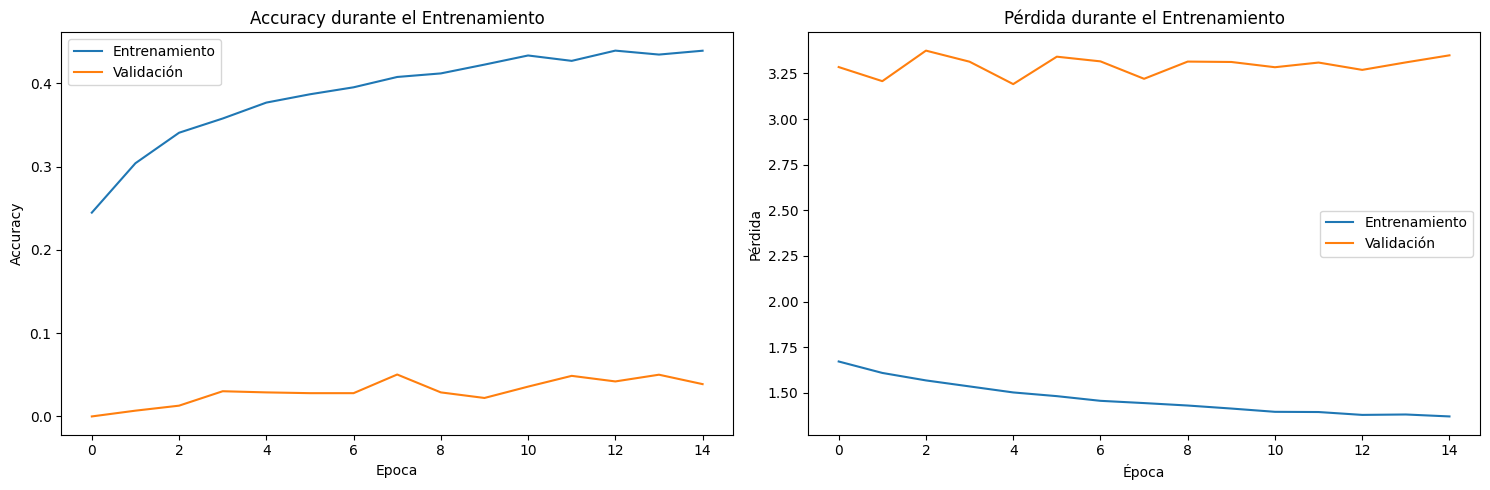

In [71]:
# visualizar el entrenamiento de la red neuronal
plt.figure(figsize=(15, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

### Optimización de Modelos: Ingenieria de Caracteristicas 2

Para mejorar el funcionamiento, vamos a comprobar si el cálculo de variables mejora la clasificación

In [72]:
# df original debe ser ordenado por Timestamp
df.sort_values(by='Timestamp', inplace=True) 

# Establecer Timestamp como el índice 
df.set_index('Timestamp', inplace=True) 

# Separar features (X) y target (y)
X_original = df.drop('Fault_Label', axis=1) # Las features originales
y_original = df['Fault_Label'].apply(lambda x: 0 if x == 'Normal' else 1) # Target binario

In [73]:
# Eliminar Fault_Label_Encoded si existe (previene data leakage)
if 'Fault_Label_Encoded' in X_original.columns:
    X_original = X_original.drop('Fault_Label_Encoded', axis=1)
    print("¡Advertencia! Se eliminó 'Fault_Label_Encoded' para prevenir data leakage")


¡Advertencia! Se eliminó 'Fault_Label_Encoded' para prevenir data leakage


In [74]:
# Realizar el split
# Si su problema no es de series de tiempo puras, puede mantener el split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_original, 
    y_original, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_original
)

# AHORA: Aplicar Feature Engineering al X_train. 
# Primero, reordenar X_train por su índice original (el Timestamp)
X_train_time_sorted = X_train.sort_index()

# Aplicar Feature Engineering
sensors = [
    'Vibration_Compressor', 'Pressure_Compressor', 'Altitude', 'Airspeed', 
    'Fuel_Flow', 'Temp_Turbine', 'Ambient_Temp', 'Speed_Turbine', 'Temp_Compressor'
]

for col in sensors:
    X_train_time_sorted[f'{col}_Change'] = X_train_time_sorted[col].diff()
    X_train_time_sorted[f'{col}_Volatility'] = X_train_time_sorted[col].rolling(window=3).std()
    X_train_time_sorted[f'{col}_Trend'] = X_train_time_sorted[col].rolling(window=3).mean()

# Eliminar los NaN generados (bfill ya no es 'data leakage' porque solo usa el set de entrenamiento)
X_train_time_sorted.fillna(method='bfill', inplace=True)
X_train_time_sorted.fillna(0, inplace=True)

# Actualizar X_train y y_train (el orden no importa para SMOTE o el Random Forest)
# Ahora X_train tiene las nuevas características
X_train_with_features = X_train_time_sorted

In [75]:
from imblearn.over_sampling import SMOTE

# X_train_res y y_train_res son ARRAYS de NumPy (han perdido el indexado por Timestamp)
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(
    X_train_with_features, 
    y_train.loc[X_train_with_features.index]
) 

# Crear el DataFrame balanceado (el orden aquí es aleatorio, pero las features 'Change', 'Trend' y 'Volatility' se han calculado de antes)
df_train_smote = pd.concat([
    pd.DataFrame(X_train_res, columns=X_train_with_features.columns), 
    pd.Series(y_train_res, name='Is_Fault')
], axis=1)

print(f"Forma del conjunto balanceado listo para el modelo: {df_train_smote.shape}")

Forma del conjunto balanceado listo para el modelo: (8250, 43)


In [76]:
df_train_smote.columns.tolist()

['Temp_Compressor',
 'Temp_Turbine',
 'Pressure_Compressor',
 'Vibration_Compressor',
 'Speed_Turbine',
 'Fuel_Flow',
 'Altitude',
 'Airspeed',
 'Ambient_Temp',
 'hour',
 'day_of_week',
 'day_of_month',
 'month',
 'weekend',
 'Month',
 'Vibration_Compressor_Change',
 'Vibration_Compressor_Volatility',
 'Vibration_Compressor_Trend',
 'Pressure_Compressor_Change',
 'Pressure_Compressor_Volatility',
 'Pressure_Compressor_Trend',
 'Altitude_Change',
 'Altitude_Volatility',
 'Altitude_Trend',
 'Airspeed_Change',
 'Airspeed_Volatility',
 'Airspeed_Trend',
 'Fuel_Flow_Change',
 'Fuel_Flow_Volatility',
 'Fuel_Flow_Trend',
 'Temp_Turbine_Change',
 'Temp_Turbine_Volatility',
 'Temp_Turbine_Trend',
 'Ambient_Temp_Change',
 'Ambient_Temp_Volatility',
 'Ambient_Temp_Trend',
 'Speed_Turbine_Change',
 'Speed_Turbine_Volatility',
 'Speed_Turbine_Trend',
 'Temp_Compressor_Change',
 'Temp_Compressor_Volatility',
 'Temp_Compressor_Trend',
 'Is_Fault']

In [77]:
X = df_train_smote.drop('Is_Fault', axis=1) # Usamos las columnas del set balanceado completo.

In [78]:
X.columns.tolist()

['Temp_Compressor',
 'Temp_Turbine',
 'Pressure_Compressor',
 'Vibration_Compressor',
 'Speed_Turbine',
 'Fuel_Flow',
 'Altitude',
 'Airspeed',
 'Ambient_Temp',
 'hour',
 'day_of_week',
 'day_of_month',
 'month',
 'weekend',
 'Month',
 'Vibration_Compressor_Change',
 'Vibration_Compressor_Volatility',
 'Vibration_Compressor_Trend',
 'Pressure_Compressor_Change',
 'Pressure_Compressor_Volatility',
 'Pressure_Compressor_Trend',
 'Altitude_Change',
 'Altitude_Volatility',
 'Altitude_Trend',
 'Airspeed_Change',
 'Airspeed_Volatility',
 'Airspeed_Trend',
 'Fuel_Flow_Change',
 'Fuel_Flow_Volatility',
 'Fuel_Flow_Trend',
 'Temp_Turbine_Change',
 'Temp_Turbine_Volatility',
 'Temp_Turbine_Trend',
 'Ambient_Temp_Change',
 'Ambient_Temp_Volatility',
 'Ambient_Temp_Trend',
 'Speed_Turbine_Change',
 'Speed_Turbine_Volatility',
 'Speed_Turbine_Trend',
 'Temp_Compressor_Change',
 'Temp_Compressor_Volatility',
 'Temp_Compressor_Trend']

Iniciando Selección de Características...


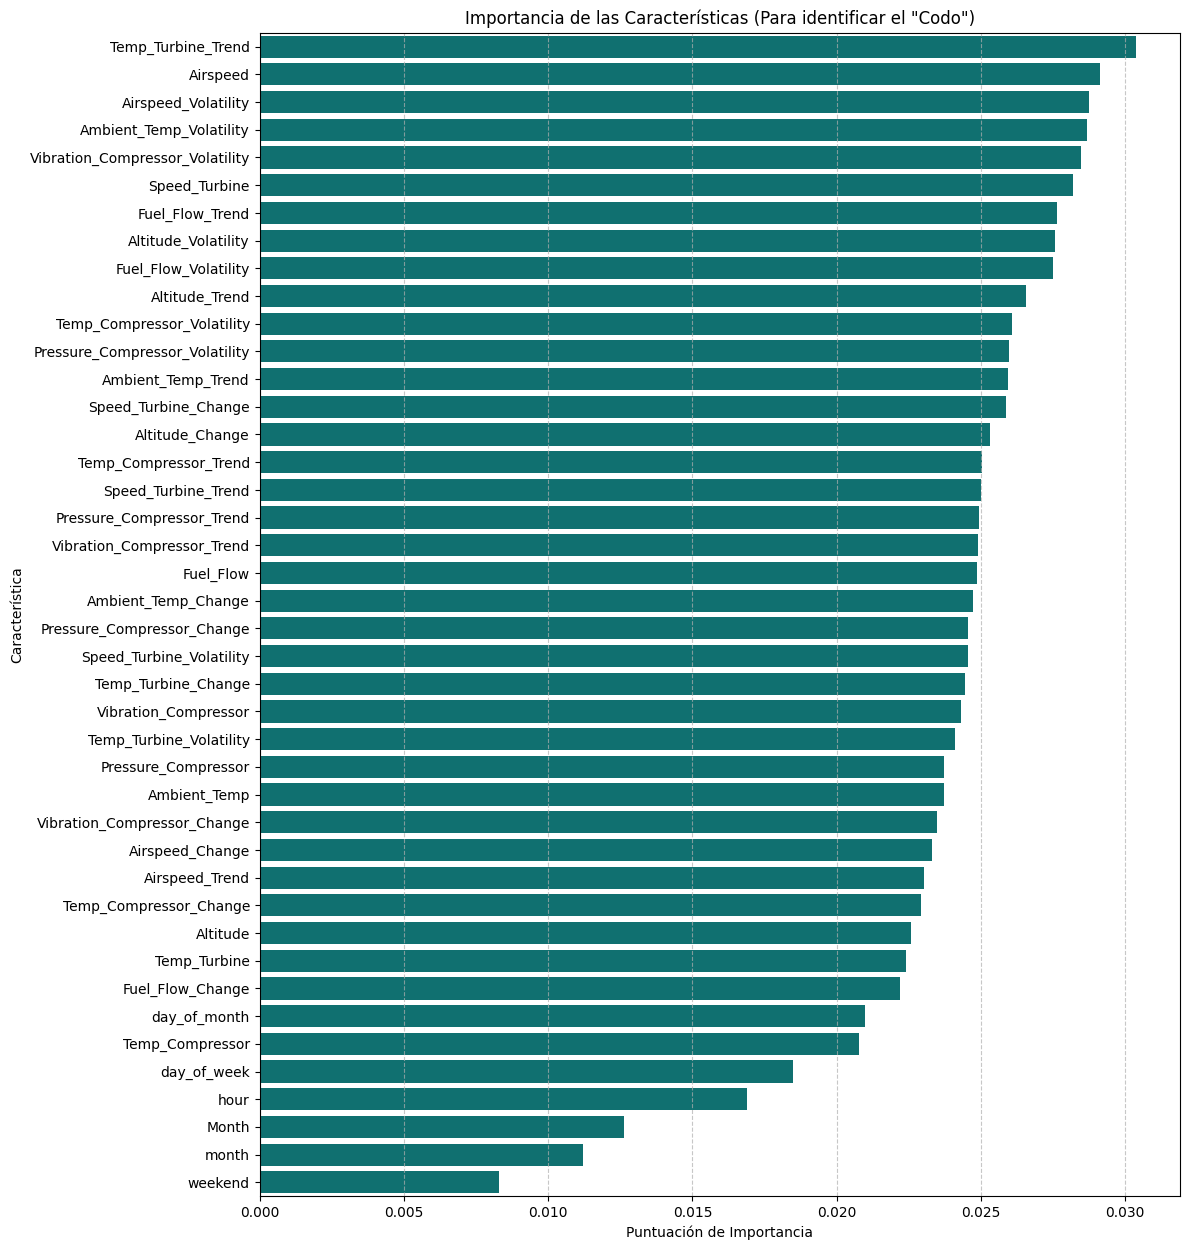

Características originales: 42
Características seleccionadas (importancia > 0.01): 41
Lista de características seleccionadas: ['Temp_Turbine_Trend', 'Airspeed', 'Airspeed_Volatility', 'Ambient_Temp_Volatility', 'Vibration_Compressor_Volatility', 'Speed_Turbine', 'Fuel_Flow_Trend', 'Altitude_Volatility', 'Fuel_Flow_Volatility', 'Altitude_Trend', 'Temp_Compressor_Volatility', 'Pressure_Compressor_Volatility', 'Ambient_Temp_Trend', 'Speed_Turbine_Change', 'Altitude_Change', 'Temp_Compressor_Trend', 'Speed_Turbine_Trend', 'Pressure_Compressor_Trend', 'Vibration_Compressor_Trend', 'Fuel_Flow', 'Ambient_Temp_Change', 'Pressure_Compressor_Change', 'Speed_Turbine_Volatility', 'Temp_Turbine_Change', 'Vibration_Compressor', 'Temp_Turbine_Volatility', 'Pressure_Compressor', 'Ambient_Temp', 'Vibration_Compressor_Change', 'Airspeed_Change', 'Airspeed_Trend', 'Temp_Compressor_Change', 'Altitude', 'Temp_Turbine', 'Fuel_Flow_Change', 'day_of_month', 'Temp_Compressor', 'day_of_week', 'hour', 'Month', '

In [79]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

umbral_importancia=0.01
print("Iniciando Selección de Características...")

#1. Entrenar un modelo base
selector_rf = RandomForestClassifier(n_estimators=50, random_state=42)
selector_rf.fit(X_train_res, y_train_res)

#2. Obtener la importancia de las características
feature_importances = pd.Series(
    selector_rf.feature_importances_,
    index=X.columns 
).sort_values(ascending=False)

# Crear DataFrame para el gráfico
df_importances = pd.DataFrame({
    'Característica': feature_importances.index,
    'Importancia': feature_importances.values
})

plt.figure(figsize=(12, min(len(feature_importances) * 0.3, 15))) # Ajusta el tamaño de la figura
sns.barplot(
    x='Importancia',
    y='Característica',
    data=df_importances,
    color='teal'
)

plt.title('Importancia de las Características (Para identificar el "Codo")')
plt.xlabel('Puntuación de Importancia')
plt.ylabel('Característica')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#3. Filtrar y seleccionar características
selected_features = feature_importances[feature_importances > umbral_importancia].index.tolist()
not_selected_features = feature_importances[feature_importances <= umbral_importancia].index.tolist()

print(f"Características originales: {X_train_res.shape[1]}")
print(f"Características seleccionadas (importancia > {umbral_importancia}): {len(selected_features)}")
print(f"Lista de características seleccionadas: {selected_features}")
print(f"Lista de características no seleccionadas: {not_selected_features}")